In [1]:
import sys
import os
sys.path.append('..')

In [2]:
from workspace import nometools as nome

In [3]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from scipy.stats import pearsonr

In [5]:
main_path = '/home/kevin/DNA-Methylation-patterns/'
data_path = main_path + 'intron_reg_start_2/'
steric_path = main_path + 'intron_reg_start_2/steric_clash/'

In [6]:
np.random.seed(1234)

#### Promoter annotation and sorting

In [7]:
infile = data_path + 'refGene'

coords_track ={}
seen_coords = set()
itr = 0
with open(infile, 'r') as fin:
    for line in fin:
        if not line.startswith('#'):
            if itr > 100:
                break

            line_s = line.strip().split('\t')

            refid = line_s[1]
            chrom = line_s[2]
            strand = line_s[3]
            txStart = int(line_s[4])
            txEnd = int(line_s[5])
            cdsStart = int(line_s[6])
            cdsEnd = int(line_s[7])
            geneName = ''.join(c for c in line_s[12] if c.isalnum())

            coords = chrom + str(txStart) + str(txEnd) + strand
            if coords not in seen_coords:
                seen_coords.add(coords)
                coords_track[coords] = line_s

                if int(line_s[8]) < 1:
                    print(line_s[8])
                # promo_start = 2000
                # promo_end = 1000

                if strand == "+":
                    # promoter_start = txStart - promo_start
                    # promoter_end = txStart + promo_end
                    pass
                else:
                    pass
                    # promoter_start = txEnd - promo_end
                    # promoter_end = txEnd + promo_start
                
                # if promoter_start < 0:
                #         promoter_start = 0

                if cdsStart != cdsEnd and geneName[0:3] != 'MIR' and geneName[0:3] != 'SNO' and '_' not in chrom:
                    # fout.write('\t'.join([str(s) for s in [chrom, promoter_start, promoter_end, refid, geneName, txStart, txEnd, strand]]) + '\n')
                    itr += 1

            else:
                print(f'same coords {coords}')
                print(line_s)
                print(coords_track[coords])
                break 

same coords chr16699927567216822+
['0', 'NM_001308203', 'chr1', '+', '66999275', '67216822', '67000041', '67208778', '22', '66999275,66999928,67091529,67098752,67105459,67108492,67109226,67136677,67137626,67138963,67142686,67145360,67154830,67155872,67160121,67184976,67194946,67199430,67205017,67206340,67206954,67208755,', '66999355,67000051,67091593,67098777,67105516,67108547,67109402,67136702,67137678,67139049,67142779,67145435,67154958,67155999,67160187,67185088,67195102,67199563,67205220,67206405,67207119,67216822,', '0', 'SGIP1', 'cmpl', 'cmpl', '-1,0,1,2,0,0,1,0,1,2,1,1,1,0,1,1,2,2,0,2,1,1,']
['0', 'NM_001376542', 'chr1', '+', '66999275', '67216822', '67000041', '67208778', '25', '66999275,66999928,67091529,67098752,67105459,67108492,67109226,67126195,67133212,67136677,67137626,67138963,67142686,67145360,67147551,67154830,67155872,67161116,67184976,67194946,67199430,67205017,67206340,67206954,67208755,', '66999620,67000051,67091593,67098777,67105516,67108547,67109402,67126207,671

In [8]:
def get_introns_refGene(infile, outfile, anchor=1, pos='start'):
    seen_coords = set()
    itr = 0
    with open(outfile, 'w') as fout:
        with open(infile, 'r') as fin:
            for line in fin:
                if not line.startswith('#'):
                    line_s = line.strip().split('\t')

                    refid = line_s[1]
                    chrom = line_s[2]
                    strand = line_s[3]
                    txStart = int(line_s[4])
                    txEnd = int(line_s[5])
                    cdsStart = int(line_s[6])
                    cdsEnd = int(line_s[7])
                    geneName = ''.join(c for c in line_s[12] if c.isalnum())

                    coords = chrom + str(txStart) + str(txEnd) + strand
                    if coords not in seen_coords:
                        seen_coords.add(coords)

                        if cdsStart != cdsEnd and geneName[0:3] != 'MIR' and geneName[0:3] != 'SNO' and '_' not in chrom:
                            assert line_s[9].endswith(',')
                            assert line_s[10].endswith(',')

                            exon_starts = np.array(list(map(int, line_s[9][:-1].strip().split(','))))
                            exon_ends = np.array(list(map(int, line_s[10][:-1].strip().split(','))))

                            assert exon_starts.shape == exon_ends.shape

                            intron_starts = exon_ends[:-1].copy()
                            intron_ends = exon_starts[1:].copy()

                            assert np.all((intron_ends - intron_starts) >= 0)

                            for i, (start, end) in enumerate(zip(intron_starts, intron_ends)):
                                if i+1 == anchor:
                                    if end > start:
                                        start_offset = 2000
                                        end_offset = 1000

                                        if pos == 'start':
                                            if strand == "+":
                                                intron_start = start - start_offset
                                                intron_end = start + end_offset
                                            else:
                                                intron_start = end - end_offset
                                                intron_end = end + start_offset
                                        
                                        elif pos == 'end':
                                            if strand == "+":
                                                intron_start = end - start_offset
                                                intron_end = end + end_offset
                                            else:
                                                intron_start = start - end_offset
                                                intron_end = start + start_offset
                                            
                                        if intron_start < 0:
                                                intron_start = 0

                                        # print('\t'.join([str(s) for s in [chrom, intron_start, intron_end, refid, geneName, txStart, txEnd, strand]]) + '\n')
                                        fout.write('\t'.join([str(s) for s in [chrom, intron_start, intron_end, refid, geneName, txStart, txEnd, strand]]) + '\n')
                                        itr += 1

                                    break

    print('no of introns defined :', itr)
    print('introns saved to {}'.format(outfile))

In [9]:
# Getting introns from refGene

infile = data_path + 'refGene'
outfile = data_path + 'refGene.introns_2_start.bed'
get_introns_refGene(infile, outfile, anchor=2, pos='start')                    

no of introns defined : 29313
introns saved to /home/kevin/DNA-Methylation-patterns/intron_reg_start_2/refGene.introns_2_start.bed


In [10]:
outfile = data_path + 'refGene.introns_2_start.bed'
print('no of introns :', nome.get_num_reads(outfile))

no of introns : 29313


In [11]:
# # sorting bed files introns

# infile = data_path + 'refGene.introns_2_start.bed'
# outfile = data_path + 'refGene.introns_2_start.sorted.bed'

# nome.sort_bed(infile, outfile)

In [12]:
## checking length of intron regions

infile = data_path + 'refGene.introns_2_start.sorted.bed'
temp = []
with open(infile, 'r') as fin:
    for line in fin:
        line_s = line.strip().split('\t')
        chrom = line_s[0]
        strand = line_s[-1]
        i_start = int(line_s[1])
        i_end = int(line_s[2])

        temp.append([chrom, i_start, i_end, strand])

df_introns = pd.DataFrame(temp, columns=['chr', 'start', 'end', 'strand'])

In [13]:
df_introns.head()

,chr,start,end,strand
0,chr1,859393,862393,+
1,chr1,859393,862393,+
2,chr1,879897,882897,-
3,chr1,894932,897932,+
4,chr1,900183,903183,+


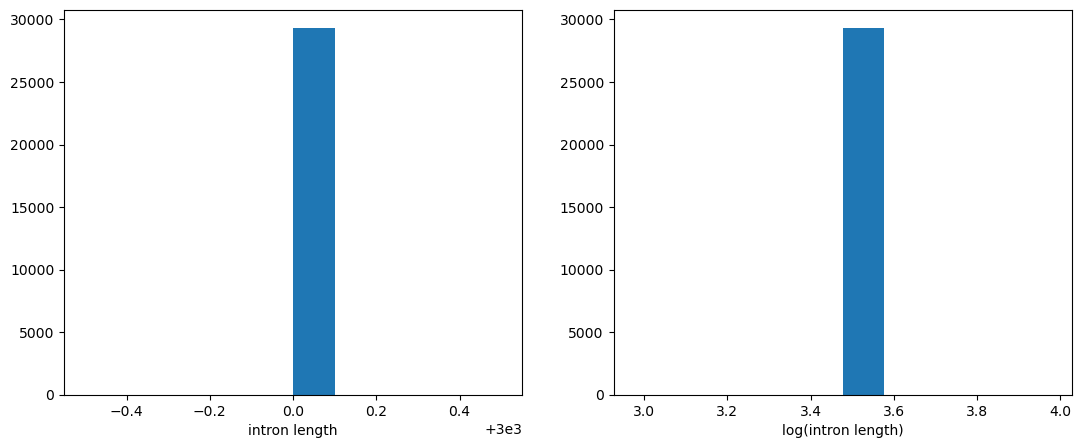

In [14]:
reg_len = df_introns['end'] - df_introns['start'] 
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.hist(reg_len)
plt.xlabel('intron length')
plt.subplot(1,2,2)
plt.hist(np.log10(reg_len))
plt.xlabel('log(intron length)')
plt.show()

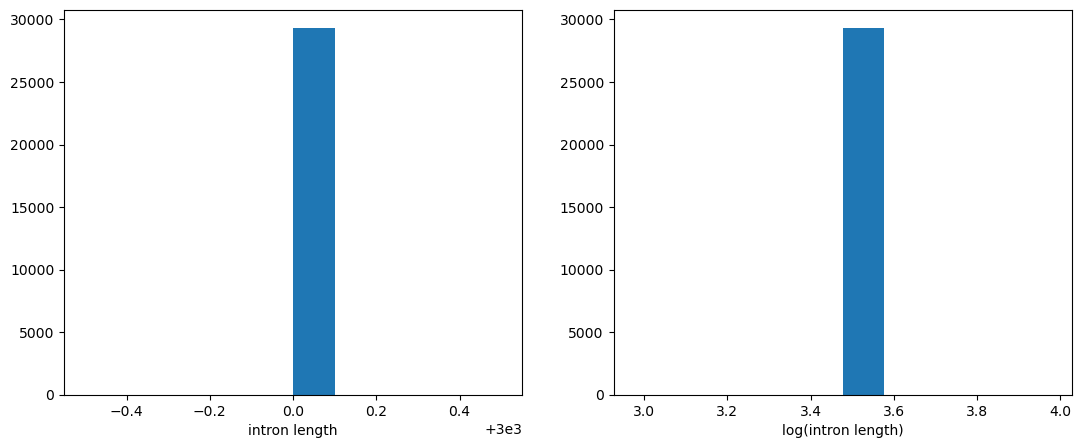

In [15]:
reg_len = df_introns['end'] - df_introns['start'] 
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.hist(reg_len[np.all(pd.concat([reg_len > 900, reg_len < 10000], axis=1), axis=1)])
plt.xlabel('intron length')
plt.subplot(1,2,2)
plt.hist(np.log10(reg_len))
plt.xlabel('log(intron length)')
plt.show()

#### GCH filtering and intersection

In [ ]:
# # Filtering GCH file
# # Filtering for reads with coverage >= 3

# infile = data_path + 'cpg.raw.sort.GCH.bed'
# outfile = data_path + 'GCH.filtered.bed'

# nome.filter_bed_files(infile, outfile)

In [ ]:
# infile = data_path + 'cpg.raw.sort.GCH.bed'
# outfile = data_path + 'GCH.filtered.bed'
# ni = nome.get_num_reads(infile)
# no = nome.get_num_reads(outfile)
# print('no of reads in GCH file :', ni)
# print('no of reads in filtered GCH file :', no)
# print('percentage of reads remaining {}%'.format(round(no*100/ni, 2)))

In [ ]:
## sorting bed files GCH

# infile = data_path + 'GCH.filtered.bed'
# outfile = data_path + 'GCH.filtered.sorted.bed'

# nome.sort_bed(infile, outfile)

In [16]:
# # GCH intersect with introns

# introns_sorted = data_path + 'refGene.introns_2_start.sorted.bed'
# gch_sorted = data_path + 'GCH.filtered.sorted.bed'
# outfile = data_path + 'GCH.introns_2_start.intersect.bed'

# nome.intersect_bed(introns_sorted, gch_sorted, outfile)

In [17]:
outfile = data_path + 'GCH.introns_2_start.intersect.bed'
print('no of reads in introns region :', nome.get_num_reads(outfile))

no of reads in introns region : 2957082


In [18]:
outfile = data_path + 'refGene.introns_2_start.sorted.bed'
print('no of introns :', nome.get_num_reads(outfile))

no of introns : 29313


In [19]:
def get_intron_methylation(infile):
    inter_dict = dict()
    seen_ids = set()

    with open(infile) as f:
        for line in f:
            line_s = line.strip().split('\t')

            chrom = line_s[0]            
            intron_start = int(line_s[1])
            intron_end = int(line_s[2])
            refid = line_s[3]
            gene_name = line_s[4]
            TSS = int(line_s[5])
            TES = int(line_s[6])
            strand = line_s[7]
            meth_start = int(line_s[9])
            meth_end = int(line_s[10])
            meth_rate = float(line_s[12])
            coverage = int(line_s[13])

            dict_id = refid + "-" + str(intron_start)
            
            ## We are checking + and -ve strands based on promoter
            if strand == "+":
                intron_abs_pos = meth_start - intron_start
            if strand == "-":
                intron_abs_pos = intron_end - meth_end
        
            rel_pos = intron_abs_pos - 2000
        
            if dict_id not in seen_ids:
                seen_ids.add(dict_id)
                inter_dict[dict_id] = dict()
            
            inter_dict[dict_id][meth_start] = dict()
            
            inter_dict[dict_id][meth_start]["chrom"] = chrom
            inter_dict[dict_id][meth_start]["intron_start"] = intron_start
            inter_dict[dict_id][meth_start]["intron_end"] = intron_end
            inter_dict[dict_id][meth_start]["gene_name"] = gene_name
            inter_dict[dict_id][meth_start]["TSS"] = TSS
            inter_dict[dict_id][meth_start]["TES"] = TES
            inter_dict[dict_id][meth_start]["strand"] = strand
            
            inter_dict[dict_id][meth_start]["meth_start_genome"] = meth_start
            inter_dict[dict_id][meth_start]["meth_end_genome"] = meth_end
            inter_dict[dict_id][meth_start]["meth_pos_intron_abs"] = intron_abs_pos
            inter_dict[dict_id][meth_start]["meth_pos_intron_rel"] = rel_pos
                        
            inter_dict[dict_id][meth_start]["meth_rate"] = meth_rate
            inter_dict[dict_id][meth_start]["coverage"] = coverage

    column_names = ['trans_id', 'refid', 'gene_name', 'chrom', 'intron_start', 'intron_end', 
                    'TSS', 'TES', 'strand', 'meth_start_genome', 'meth_end_genome', 'meth_pos_intron_abs', 'meth_pos_intron_rel', 'meth_rate', 'coverage']

    info_dict = dict()
    for col in column_names:
        info_dict[col] = []

    ## Can create a filter for no of GCH or HCG in a promoter
    for dict_id in inter_dict.keys():
        refid = dict_id.split("-")[0]
        for promo_start in inter_dict[dict_id].keys():
            info_dict["trans_id"].append(dict_id)
            info_dict["refid"].append(refid)
            info_dict["gene_name"].append(inter_dict[dict_id][promo_start]["gene_name"])
            info_dict["chrom"].append(inter_dict[dict_id][promo_start]["chrom"])
            info_dict["intron_start"].append(inter_dict[dict_id][promo_start]["intron_start"])
            info_dict["intron_end"].append(inter_dict[dict_id][promo_start]["intron_end"])
            info_dict["TSS"].append(inter_dict[dict_id][promo_start]["TSS"])
            info_dict["TES"].append(inter_dict[dict_id][promo_start]["TES"])
            info_dict["strand"].append(inter_dict[dict_id][promo_start]["strand"])
            
            info_dict["meth_start_genome"].append(inter_dict[dict_id][promo_start]["meth_start_genome"])
            info_dict["meth_end_genome"].append(inter_dict[dict_id][promo_start]["meth_end_genome"])
            info_dict["meth_pos_intron_abs"].append(inter_dict[dict_id][promo_start]["meth_pos_intron_abs"])
            info_dict["meth_pos_intron_rel"].append(inter_dict[dict_id][promo_start]["meth_pos_intron_rel"])
            
            info_dict["meth_rate"].append(inter_dict[dict_id][promo_start]["meth_rate"])
            info_dict["coverage"].append(inter_dict[dict_id][promo_start]["coverage"])

    # Built dataframe
    df = pd.DataFrame(0, index = np.arange(len(info_dict["refid"])), columns = column_names)
    for feat in column_names:
        df[feat] = info_dict[feat]  
        
    df = df.sort_values(by = ['chrom', 'intron_start'], ascending = [True, True])

    return df

In [20]:
infile = data_path + 'GCH.introns_2_start.intersect.bed'
df = get_intron_methylation(infile)

In [21]:
df.head()

,trans_id,refid,gene_name,chrom,intron_start,intron_end,TSS,TES,strand,meth_start_genome,meth_end_genome,meth_pos_intron_abs,meth_pos_intron_rel,meth_rate,coverage
0,NM_001385640-859393,NM_001385640,SAMD11,chr1,859393,862393,859302,879954,+,859886,859887,493,-1507,33.33,3
1,NM_001385640-859393,NM_001385640,SAMD11,chr1,859393,862393,859302,879954,+,860034,860035,641,-1359,33.33,3
2,NM_001385640-859393,NM_001385640,SAMD11,chr1,859393,862393,859302,879954,+,860038,860039,645,-1355,33.33,3
3,NM_001385640-859393,NM_001385640,SAMD11,chr1,859393,862393,859302,879954,+,861726,861727,2333,333,25.00,4
4,NM_001385640-859393,NM_001385640,SAMD11,chr1,859393,862393,859302,879954,+,861731,861732,2338,338,25.00,4


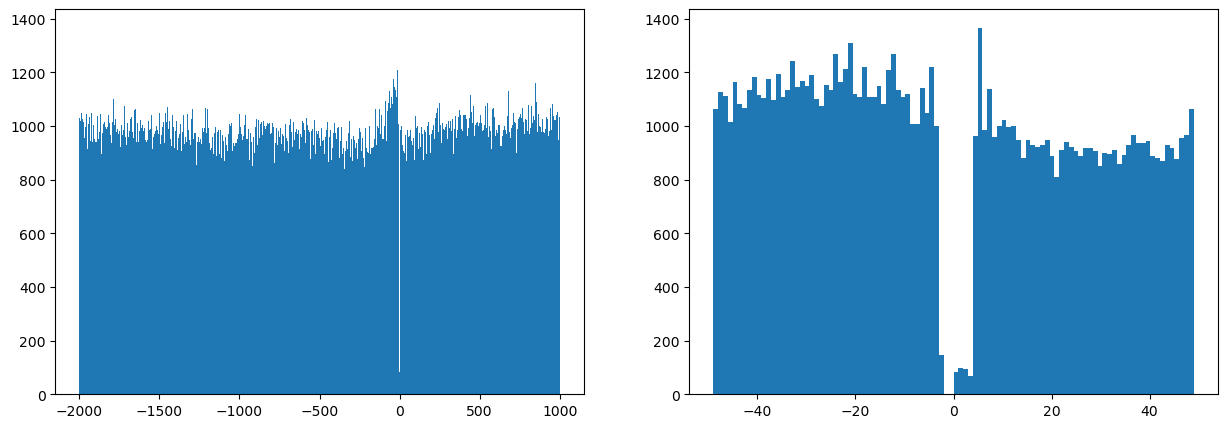

In [22]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(df['meth_pos_intron_rel'], bins=3000)
plt.subplot(1,2,2)
plt.hist(df['meth_pos_intron_rel'][np.all(pd.concat((df['meth_pos_intron_rel'] > -50, df['meth_pos_intron_rel'] < 50), axis=1), axis=1)], bins=100)
plt.show()

In [23]:
df.shape

(2947493, 15)

In [24]:
print('no of introns : ', df['trans_id'].unique().shape)

no of introns :  (28817,)


In [25]:
print('no of introns : ', df['gene_name'].unique().shape)

no of introns :  (16471,)


In [26]:
temp = pd.read_csv(data_path + 'refGene.introns_2_start.bed', sep='\t', header=None, names=['chr',	'intron_start',	'intron_end', 'trans_id',
                                                                                     'gene_name', 'TSS', 'TES', 'strand'])
print('no of introns : ', df['gene_name'].unique().shape)

no of introns :  (16471,)


In [27]:
def plot_avg_methylation_levels(df, context, select_genes=[], fig = True, c = 'grey', label = None, rel=False, inter_start=None, inter_end=None):
    
    if len(select_genes) == 0: 
        all_meth_pos_promo_rel = list(df['meth_pos_intron_rel'])
        all_meth_rate = list(df['meth_rate'])
        all_coverage = list(df['coverage'])

        assert len(all_meth_pos_promo_rel) == len(all_meth_rate) == len(all_coverage)

        av_dict = dict()
        seen_pos = set()
        for p in range(len(all_meth_pos_promo_rel)):
            rel_pos_x = all_meth_pos_promo_rel[p]
            meth_rate = all_meth_rate[p]
            coverage = all_coverage[p]
            
            #AVERAGE
            if rel_pos_x not in seen_pos:
                seen_pos.add(rel_pos_x)
                av_dict[rel_pos_x] = {}
                av_dict[rel_pos_x]['meth'] = []
                av_dict[rel_pos_x]['total'] = []
            
            if context == 'GCH':
                av_dict[rel_pos_x]['meth'].append(coverage*(100-meth_rate)/100)
                av_dict[rel_pos_x]['total'].append(coverage)
            elif context == 'HCG':
                av_dict[rel_pos_x]['meth'].append(meth_rate*coverage/100)
                av_dict[rel_pos_x]['total'].append(coverage)
            else:
                print('Check context')
                return
    else:
        av_dict = {}
        seen_pos = set()
        # group = df[df['refid'].isin(select_genes)]
        group = df[df['gene_name'].isin(select_genes)]
        for rel_pos_x, meth_rate, coverage in zip(group['meth_pos_intron_rel'], group['meth_rate'], group['coverage']):
            if rel_pos_x not in seen_pos:
                seen_pos.add(rel_pos_x)
                av_dict[rel_pos_x] = {}
                av_dict[rel_pos_x]['meth'] = []
                av_dict[rel_pos_x]['total'] = []

            if context == 'GCH':
                av_dict[rel_pos_x]['meth'].append(coverage*(100-meth_rate)/100)
                av_dict[rel_pos_x]['total'].append(coverage)
            elif context == 'HCG':
                av_dict[rel_pos_x]['meth'].append(meth_rate*coverage/100)
                av_dict[rel_pos_x]['total'].append(coverage)
            else:
                print('Check context')
                return
            

    if fig:
        plt.figure(figsize=(15, 7), facecolor='w', edgecolor='k')

    x = []
    y = []

    for rel_pos_x in sorted(av_dict.keys()):
        if rel:
            if rel_pos_x >= inter_start and rel_pos_x <= inter_end:
                if len(av_dict[rel_pos_x]['meth']) >= 3:
                    x.append(rel_pos_x)
                    y.append(np.sum(av_dict[rel_pos_x]['meth'])*100/np.sum(av_dict[rel_pos_x]['total']))
        else:
            if len(av_dict[rel_pos_x]['meth']) >= 3:
                x.append(rel_pos_x)
                y.append(np.sum(av_dict[rel_pos_x]['meth'])*100/np.sum(av_dict[rel_pos_x]['total']))

    if label is None:
        plt.plot(x, y, "-", color=c, alpha=1.0)
    else:
        plt.plot(x, y, "-", color=c, label=label, alpha=0.7)
        plt.legend()
        
    plt.xlabel("DNA position [bp]")

    if context == 'GCH':
        ylab = "100-GpC methylation level"
    if context == 'HCG':
        ylab = "CpG methylation level"
    plt.ylabel(ylab)

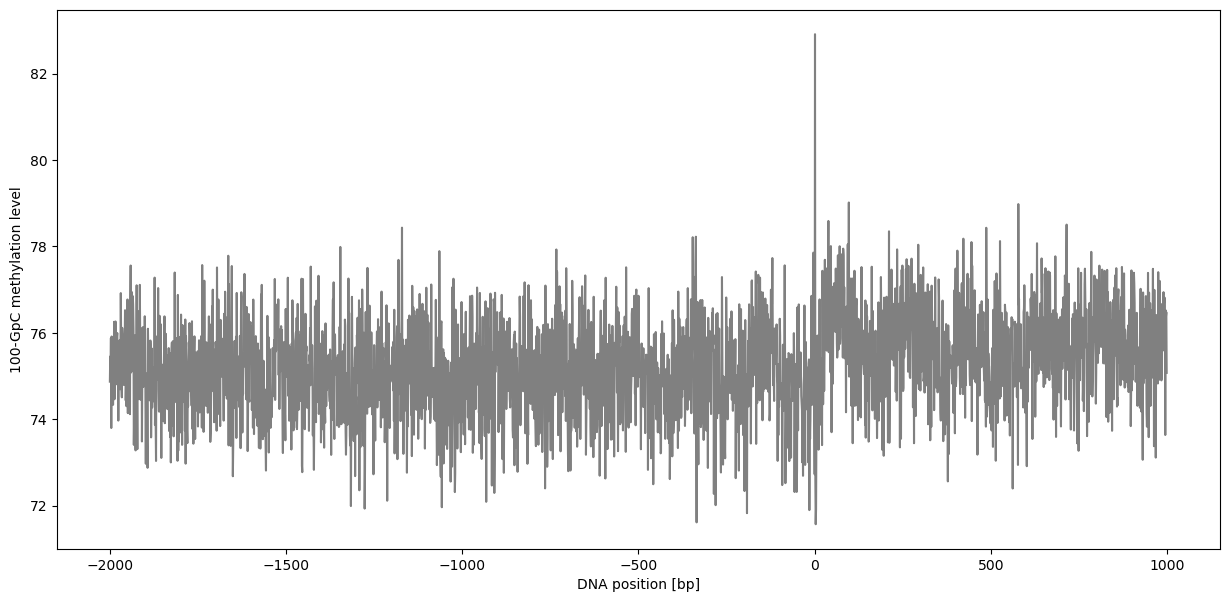

In [28]:
plot_avg_methylation_levels(df, 'GCH')

In [ ]:
# plot_avg_methylation_levels(df, 'GCH', rel=True, inter_start=0, inter_end=1000)

In [ ]:
df.head()

In [ ]:
print('no of introns : ', df['gene_name'].unique().shape)

In [ ]:
gene_groups = df.groupby('gene_name')


for i, (name, group) in enumerate(gene_groups):
    plt.figure()
    plt.plot(group['meth_pos_intron_rel'], 100-group['meth_rate'], 'o')

    pdata = {}
    for rel, rate, cov in zip(group['meth_pos_intron_rel'], group['meth_rate'], group['coverage']):
        if rel not in pdata:
            pdata[rel] = []
            pdata[rel].append(100-rate)
        else:
            pdata[rel].append(100-rate)

    x = []
    y = []
    for rel_pos_x in sorted(pdata.keys()):
        if rel_pos_x >= -2000 and rel_pos_x <= 1000:
            x.append(rel_pos_x)
            y.append(np.mean(pdata[rel_pos_x]))
    
    plt.plot(x, y, 'o-')
    
    if i==5:
        break

In [ ]:
context = 'GCH'
av_dict = dict()
seen_pos = set()
for i, (rel_pos_x, meth_rate, coverage) in enumerate(zip(df['meth_pos_intron_rel'], df['meth_rate'], df['coverage'])):
    if rel_pos_x not in seen_pos:
        seen_pos.add(rel_pos_x)
        av_dict[rel_pos_x] = {}
        av_dict[rel_pos_x]['meth'] = []
        av_dict[rel_pos_x]['total'] = []
    
    if context == 'GCH':
        av_dict[rel_pos_x]['meth'].append(int(coverage*(100-meth_rate)/100))
        av_dict[rel_pos_x]['total'].append(coverage)
    elif context == 'HCG':
        av_dict[rel_pos_x]['meth'].append(meth_rate*coverage)
        av_dict[rel_pos_x]['total'].append(coverage)
    else:
        print('Check context')
    
x = []
y = []

for rel_pos_x in sorted(av_dict.keys()):
    if rel_pos_x >= -2000 and rel_pos_x <= 1000:
        x.append(rel_pos_x)
        y.append(np.sum(av_dict[rel_pos_x]['meth'])*100/np.sum(av_dict[rel_pos_x]['total']))


gch_meth = np.ones(3001) * np.inf
mask = np.zeros(3001, dtype=bool)
mask[np.array(x) + 2000] = True
gch_meth[np.array(x) + 2000] = np.array(y)

gene_groups = df.groupby('gene_name')
counter = 0
gene_corr = {}
for i, (name, group) in enumerate(gene_groups):
    pdata = {}
    for rel, rate, cov in zip(group['meth_pos_intron_rel'], group['meth_rate'], group['coverage']):
        if rel not in pdata:
            pdata[rel] = []
            pdata[rel].append(100-rate)
        else:
            pdata[rel].append(100-rate)

    x = []
    y = []
    for rel_pos_x in sorted(pdata.keys()):
        if rel_pos_x >= -2000 and rel_pos_x <= 1000:
            x.append(rel_pos_x)
            y.append(np.mean(pdata[rel_pos_x]))

    if len(x) < 3:
        ## min one deg of freedom
        continue
    
    gene_corr[name] = {}

    gch_meth_gene = np.ones(3001) * np.inf
    mask_gene = np.zeros(3001, dtype=bool)
    mask_gene[np.array(x) + 2000] = True
    gch_meth_gene[np.array(x) + 2000] = np.array(y)

    # corr = np.corrcoef(gch_meth_gene[mask_gene], gch_meth[mask_gene])[0][1]
    # weighted_coor = corr*np.sum(mask_gene)/mask_gene.shape[0]

    corr, p_value = pearsonr(gch_meth_gene[mask_gene], gch_meth[mask_gene], alternative='greater')
    weighted_coor = corr*np.sum(mask_gene)/mask_gene.shape[0]

    assert corr - np.corrcoef(gch_meth_gene[mask_gene], gch_meth[mask_gene])[0][1] < 1e-3

    gene_corr[name]['corr'] = corr
    gene_corr[name]['n'] = np.sum(mask_gene)
    gene_corr[name]['weighted_corr'] = weighted_coor

    if weighted_coor > 0.01:
        counter += 1
        print(i, weighted_coor, corr, p_value, np.sum(mask_gene))
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.plot(x, gch_meth_gene[mask_gene])
        plt.plot(x, gch_meth[mask_gene])
        plt.subplot(1,2,2)
        plt.scatter(gch_meth_gene[mask_gene], gch_meth[mask_gene])
        plt.show()

        if counter > 5:
            break
    

In [ ]:
df.head()

In [ ]:
context = 'GCH'
av_dict = dict()
seen_pos = set()
for i, (rel_pos_x, meth_rate, coverage) in enumerate(zip(df['meth_pos_intron_rel'], df['meth_rate'], df['coverage'])):
    if rel_pos_x not in seen_pos:
        seen_pos.add(rel_pos_x)
        av_dict[rel_pos_x] = {}
        av_dict[rel_pos_x]['meth'] = []
        av_dict[rel_pos_x]['total'] = []
    
    if context == 'GCH':
        av_dict[rel_pos_x]['meth'].append(int(coverage*(100-meth_rate)/100))
        av_dict[rel_pos_x]['total'].append(coverage)
    elif context == 'HCG':
        av_dict[rel_pos_x]['meth'].append(meth_rate*coverage)
        av_dict[rel_pos_x]['total'].append(coverage)
    else:
        print('Check context')
    
x = []
y = []

for rel_pos_x in sorted(av_dict.keys()):
    if rel_pos_x >= -2000 and rel_pos_x <= 1000:
        x.append(rel_pos_x)
        y.append(np.sum(av_dict[rel_pos_x]['meth'])*100/np.sum(av_dict[rel_pos_x]['total']))

gch_meth = np.ones(3001) * np.inf
mask = np.zeros(3001, dtype=bool)
mask[np.array(x) + 2000] = True
gch_meth[np.array(x) + 2000] = np.array(y)

gene_groups = df.groupby('gene_name')
counter = 0
gene_corr = {}
for i, (name, group) in enumerate(gene_groups):
    
    # if len(group['TSS'].unique()) > 4:
    #     print(group)
    #     print('gene name = ', name)
    #     print(group['refid'].unique())
    #     print(group[['refid', 'intron_start', 'intron_end']].drop_duplicates())
    #     break

    pdata = {}
    for rel, rate, cov in zip(group['meth_pos_intron_rel'], group['meth_rate'], group['coverage']):
        if rel not in pdata:
            pdata[rel] = []
            pdata[rel].append(100-rate)
        else:
            pdata[rel].append(100-rate)

    x = []
    y = []
    for rel_pos_x in sorted(pdata.keys()):
        if rel_pos_x >= -2000 and rel_pos_x <= 1000:
            x.append(rel_pos_x)
            y.append(np.mean(pdata[rel_pos_x]))

    if len(x) < 3:
        ## min one deg of freedom
        continue
    
    gene_corr[name] = {}

    gch_meth_gene = np.ones(3001) * np.inf
    mask_gene = np.zeros(3001, dtype=bool)
    mask_gene[np.array(x) + 2000] = True
    gch_meth_gene[np.array(x) + 2000] = np.array(y)

    corr, p_value = pearsonr(gch_meth_gene[mask_gene], gch_meth[mask_gene], alternative='greater')
    weighted_coor = corr*np.sum(mask_gene)/mask_gene.shape[0]

    gene_corr[name]['corr'] = corr
    gene_corr[name]['n'] = np.sum(mask_gene)
    gene_corr[name]['weighted_corr'] = weighted_coor    
    gene_corr[name]['p_value'] = p_value

In [ ]:
n_tests = len(gene_corr)
for gene in gene_corr:
    gene_corr[gene]['corrected_p_value'] = n_tests*gene_corr[gene]['p_value']

Distribution of correlation and p values

In [ ]:
x = []
for key in gene_corr:
    x.append(gene_corr[key]['corr'])

plt.title('correlation')
plt.hist(x, bins=50)
plt.show()

x = []
for key in gene_corr:
    x.append(gene_corr[key]['weighted_corr'])

plt.title('weighted correlation')
plt.hist(x, bins=50)
plt.show()

x = []
for key in gene_corr:
    x.append(gene_corr[key]['p_value'])

plt.title('p value')
plt.hist(x, bins=50)
plt.show()

In [ ]:
selected_genes = []
not_selected_genes = []
x = {}
for gene in gene_corr:
    for key in gene_corr[gene]:
        x[key] = []

    break

for gene in gene_corr:
    if gene_corr[gene]['weighted_corr'] > 0.01:
        selected_genes.append(gene)
        for key in x:
            x[key].append(gene_corr[gene][key])
    else:
        not_selected_genes.append(gene)

print(f'# selected genes = {len(selected_genes)}')

for key in x:
    plt.figure()
    plt.title(key)
    plt.hist(x[key], bins=50)

plt.show()

In [ ]:
# selected_genes = []
# not_selected_genes = []
# x = {}
# for gene in gene_corr:
#     for key in gene_corr[gene]:
#         x[key] = []

#     break

# for gene in gene_corr:
#     if gene_corr[gene]['corrected_p_value'] < 0.05:
#         selected_genes.append(gene)
#         for key in x:
#             x[key].append(gene_corr[gene][key])
#     else:
#         not_selected_genes.append(gene)

# print(f'# selected genes = {len(selected_genes)}')

# for key in x:
#     plt.figure()
#     plt.title(key)
#     plt.hist(x[key], bins=50)

# plt.show()

In [ ]:
plot_avg_methylation_levels(df, 'GCH', select_genes=selected_genes)

In [ ]:
plot_avg_methylation_levels(df, 'GCH', select_genes=selected_genes, fig = True, c = 'grey', label = 'selected genes')
plot_avg_methylation_levels(df, 'GCH', select_genes=not_selected_genes, fig = False, c = '#333232', label = 'not selected genes')

In [ ]:
# outfile = data_path + 'selected_genes_introns.txt'
# with open(outfile, 'w') as fout:
#     for gene in selected_genes:
#         fout.write(gene + '\n')

Filter out the pos of introns for the selected genes

In [ ]:
'''
    Write out selection annotations into bed file
'''
# infile = data_path + 'refGene.introns.anchor_start.sorted.bed'
# outfile = data_path + 'refGene.introns.anchor_start.sorted.selection.bed'
# with open(outfile, 'w') as fout:
#     with open(infile, 'r') as fin: 
#         for line in fin:
#             line_s = line.strip().split('\t')
#             gene = line_s[4]

#             if gene in selected_genes:
#                 fout.write(line)

GCH intersection and profile on selection \
Should have the same profile as before - sanity check

In [ ]:
# # GCH intersect with promoter

# promoters_sorted = data_path + 'refGene.introns.anchor_start.sorted.selection.bed'
# gch_sorted = data_path + 'GCH.filtered.sorted.bed'
# outfile = data_path + 'GCH.introns.intersect.selection.bed'

# nome.intersect_bed(promoters_sorted, gch_sorted, outfile)

In [ ]:
infile = data_path + 'GCH.introns.intersect.selection.bed'
df = get_intron_methylation(infile)

In [ ]:
df.head()

In [ ]:
plot_avg_methylation_levels(df, 'GCH')

#### HCG part

In [29]:
# # HCG intersect with promoter

# introns_sorted = data_path + 'refGene.introns_2_start.sorted.bed'
# hcg_sorted = data_path + 'HCG.filtered.sorted.bed'
# outfile = data_path + 'HCG.introns.intersect.bed'

# nome.intersect_bed(introns_sorted, hcg_sorted, outfile)

In [30]:
infile = data_path + 'HCG.introns.intersect.bed'
df = get_intron_methylation(infile)

In [31]:
df.head()

,trans_id,refid,gene_name,chrom,intron_start,intron_end,TSS,TES,strand,meth_start_genome,meth_end_genome,meth_pos_intron_abs,meth_pos_intron_rel,meth_rate,coverage
0,NM_001385640-859393,NM_001385640,SAMD11,chr1,859393,862393,859302,879954,+,859870,859871,477,-1523,0.0,3
1,NM_001385640-859393,NM_001385640,SAMD11,chr1,859393,862393,859302,879954,+,859879,859880,486,-1514,0.0,3
2,NM_001385640-859393,NM_001385640,SAMD11,chr1,859393,862393,859302,879954,+,860042,860043,649,-1351,0.0,3
3,NM_001385640-859393,NM_001385640,SAMD11,chr1,859393,862393,859302,879954,+,861720,861721,2327,327,0.0,4
4,NM_001385640-859393,NM_001385640,SAMD11,chr1,859393,862393,859302,879954,+,861747,861748,2354,354,0.0,4


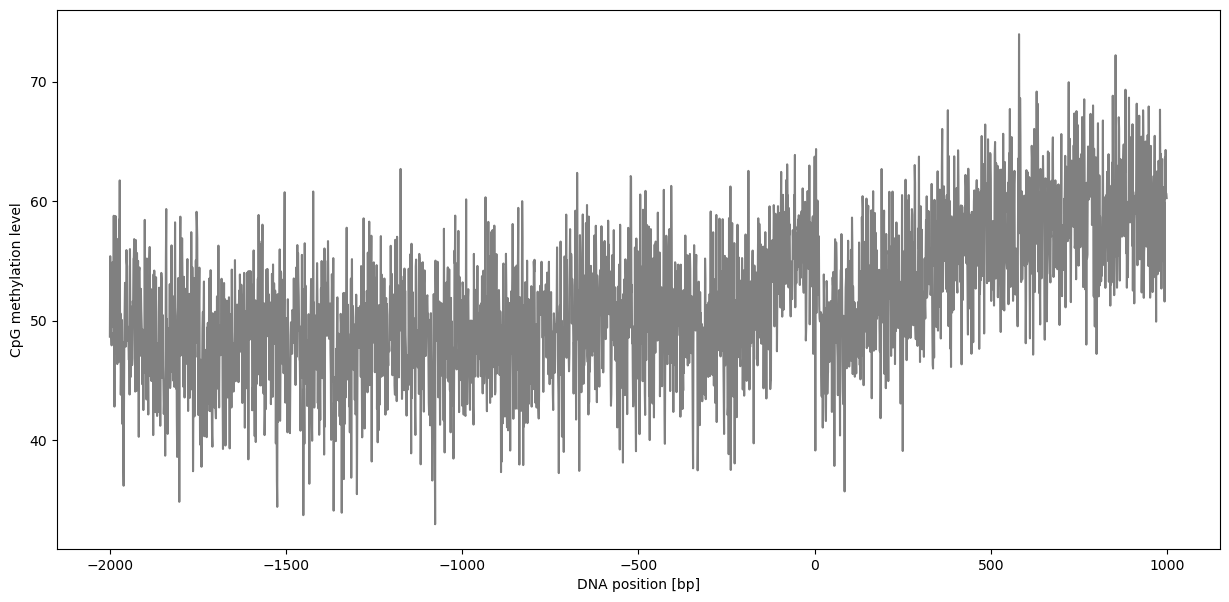

In [32]:
plot_avg_methylation_levels(df, 'HCG')

In [ ]:
# plot_avg_methylation_levels(df, 'HCG', select_genes=selected_genes, fig = True, c = 'grey', label = 'selected genes')
# plot_avg_methylation_levels(df, 'HCG', select_genes=not_selected_genes, fig = False, c = '#333232', label = 'not selected genes')

In [33]:
df_random = df.copy()
df_random['meth_rate'] = df_random['meth_rate'].sample(frac=1).reset_index(drop=True)

In [34]:
outfile = data_path + 'HCG.random.introns.intersect.bed'
cols = ['chrom', 'intron_start', 'intron_end', 'refid', 'gene_name', 'TSS', 'TES', 'strand', 'chrom', 'meth_start_genome', 'meth_end_genome', 'strand', 'meth_rate', 'coverage']
df_random[cols].to_csv(outfile, sep='\t', header=False, index=False)

In [35]:
infile = data_path + 'HCG.random.introns.intersect.bed'
df_random = get_intron_methylation(infile)

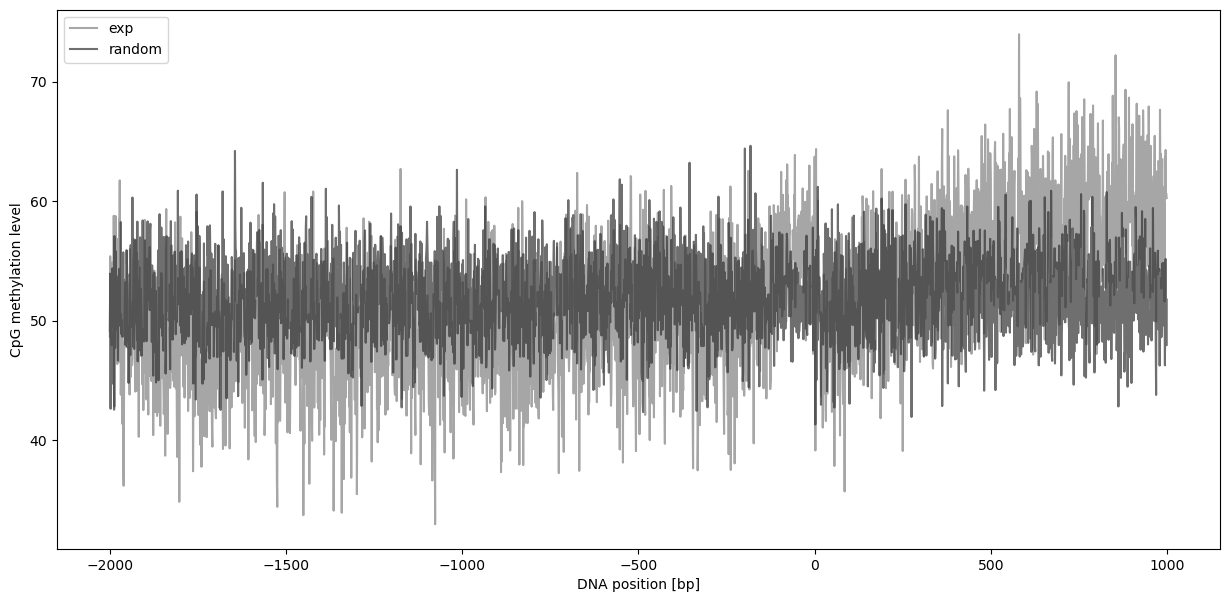

In [36]:
plot_avg_methylation_levels(df, 'HCG', label='exp')
plot_avg_methylation_levels(df_random, 'HCG', fig=False, c='#333232', label='random')

We have a good profile in the not selected set - What should we focus on when we do selection

HCG intersection and profile on selection

In [ ]:
# # HCG intersect with promoter

# introns_sorted = data_path + 'refGene.introns.anchor_start.sorted.selection.bed'
# hcg_sorted = data_path + 'HCG.filtered.sorted.bed'
# outfile = data_path + 'HCG.introns.intersect.selection.bed'

# nome.intersect_bed(introns_sorted, hcg_sorted, outfile)

In [ ]:
infile = data_path + 'HCG.introns.intersect.selection.bed'
df = get_intron_methylation(infile)

In [ ]:
df.head()

In [ ]:
plot_avg_methylation_levels(df, 'HCG')

In [ ]:
# df_random = df.copy()
# df_random['meth_rate'] = df_random['meth_rate'].sample(frac=1).reset_index(drop=True)

In [ ]:
# outfile = data_path + 'HCG.random.introns.intersect.selection.bed'
# cols = ['chrom', 'intron_start', 'intron_end', 'refid', 'gene_name', 'TSS', 'TES', 'strand', 'chrom', 'meth_start_genome', 'meth_end_genome', 'strand', 'meth_rate', 'coverage']
# df_random[cols].to_csv(outfile, sep='\t', header=False, index=False)

In [ ]:
infile = data_path + 'HCG.random.introns.intersect.selection.bed'
df_random = get_intron_methylation(infile)

In [ ]:
df_random.head()

In [ ]:
plot_avg_methylation_levels(df, 'HCG', label='exp')
plot_avg_methylation_levels(df_random, 'HCG', fig=False, c='#333232', label='random')

#### Rest of pipeline for the full genome

In [37]:
def plot_CpG_CpG_dist(df, max_dist=20, c='grey'):
    dist_list = []
    chroms = ['chr' + str(i) for i in range(1,23)] + ['chrX', 'chrY']
    for chrom in chroms:
        #### ALL methylated pos
        all_meth_pos = list(df.loc[(df["meth_rate"] != 0) & 
                                                    (df["chrom"] == chrom)]["meth_start_genome"])
        all_meth_pos_sorted = sorted(list(set(all_meth_pos))) # since mapped to promoter, CpG can be twice if promoter overlap, make set

        for pos in range(len(all_meth_pos_sorted) - 1):
            start = all_meth_pos_sorted[pos]
            next_start = all_meth_pos_sorted[pos+1]
            dist = next_start - start - 1 # is number of bases inbetween
            
            if dist <= max_dist:
                dist_list.append(dist)

    y = []
    for r in range(max_dist+1):
        freq = float(dist_list.count(r))/float(len(dist_list))*100
        y.append(freq)


    plt.figure(figsize=(10, 8), facecolor='w', edgecolor='k')

    x = np.arange(len(y))
    plt.bar(x, y, align='center', color=c)

    plt.xlabel("Distance to next 5meC [bp]")
    plt.ylabel("Percentage [%]")
    plt.xlim(1, max_dist+1)
    plt.xticks(x, range(max_dist+1))
    plt.ylim(0, 10)

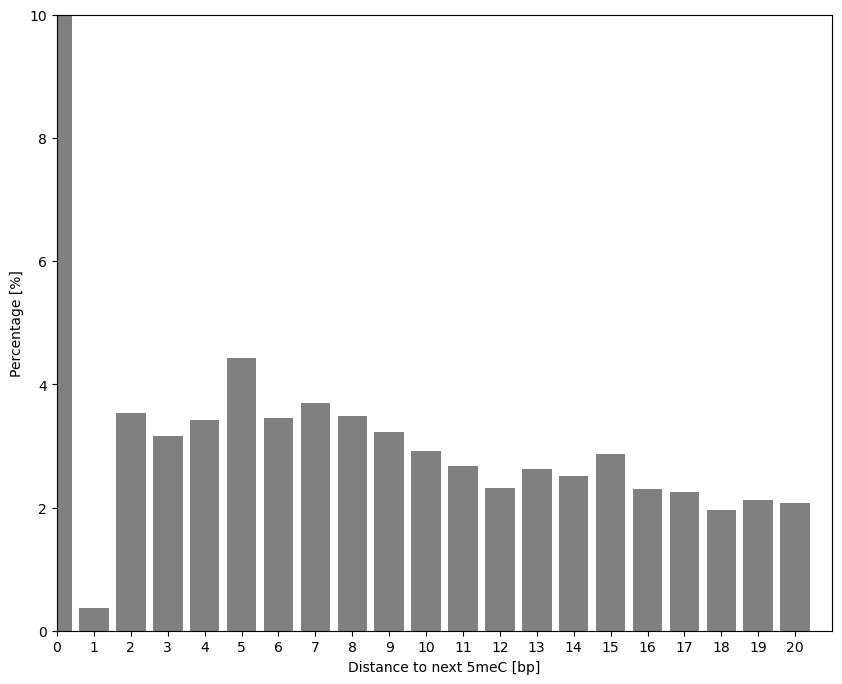

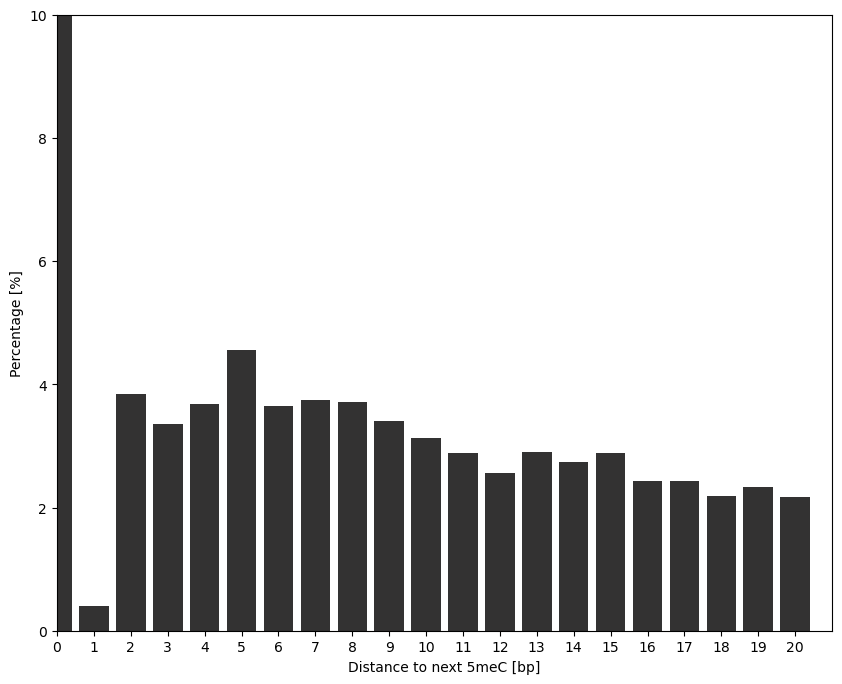

In [38]:
plot_CpG_CpG_dist(df)
plot_CpG_CpG_dist(df_random, c='#333232')

In [39]:
## we can use same NOR and NDR file

In [41]:
promoters_sorted = data_path + 'refGene.introns_2_start.sorted.bed'
ndrfile = data_path + 'NDR.bed'
outfile = data_path + 'NDR.introns.intersect.bed'
nome.intersect_bed(promoters_sorted, ndrfile, outfile)

In [42]:
infile = data_path + 'NDR.introns.intersect.bed'
df = nome.get_nuc_positions(infile)

In [43]:
df.head()

,trans_id,refid,gene_name,chrom,promoter_start,promoter_end,TSS,TES,strand,nuc_region_start_genome,nuc_region_end_genome,nuc_start_promo_abs,nuc_end_promo_abs,nuc_start_promo_rel,nuc_end_promo_rel,region_length
0,NM_198317-894932,NM_198317,KLHL17,chr1,894932,897932,895963,901099,+,896516,896916,1584,1984,-416,-16,400
1,NM_001291367-913260,NM_001291367,PERM1,chr1,913260,916260,910577,917473,-,914096,914316,1944,2164,-56,164,220
2,NM_001369898-913260,NM_001369898,PERM1,chr1,913260,916260,910577,916553,-,914096,914316,1944,2164,-56,164,220
3,NM_001014980-1177441,NM_001014980,C1QTNF12,chr1,1177441,1180441,1177832,1182102,-,1178016,1178216,2225,2425,225,425,200
4,NM_001256460-1246605,NM_001256460,INTS11,chr1,1246605,1249605,1246964,1260067,-,1247236,1247436,2169,2369,169,369,200


In [44]:
df_filtered = df.copy()

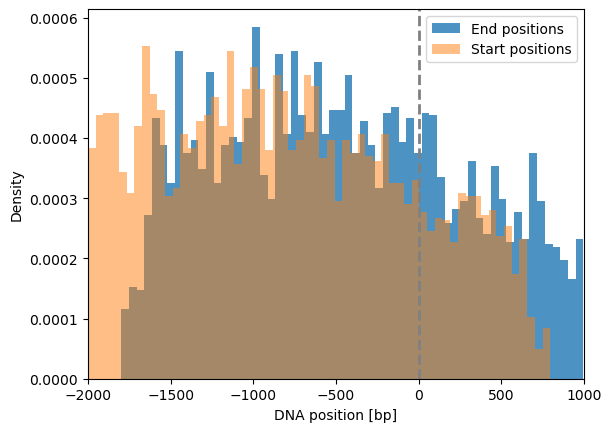

In [45]:
inter_start = -2000
inter_end = 1000
step = 200
inter = range(inter_start,inter_end+1,step)

plt.figure()

plt.hist(df_filtered['nuc_end_promo_rel'],  bins = 60, histtype='bar', density=True, label="End positions", alpha = 0.8)  
plt.hist(df_filtered['nuc_start_promo_rel'], bins = 60, histtype='bar', density=True, label="Start positions", alpha = 0.5)   

plt.xlabel("DNA position [bp]")
plt.ylabel("Density")

plt.xlim(-2000,1000)
plt.axvline(x=0, linestyle='dashed', linewidth=2, color='grey')
plt.legend()
plt.show()

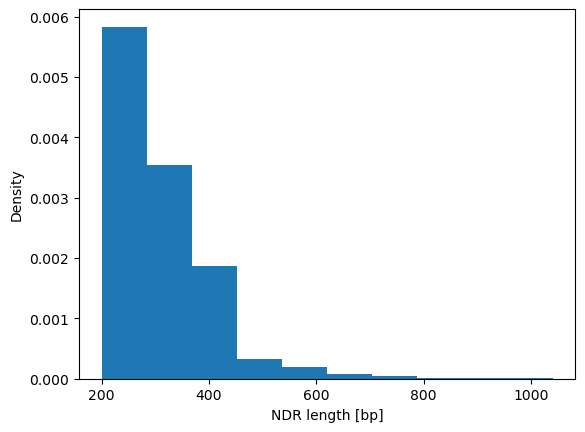

In [46]:
plt.figure()

plt.hist(df_filtered['region_length'], bins=10, histtype='bar', density=True)  

plt.xlabel("NDR length [bp]")
plt.ylabel("Density")
plt.show()

In [47]:
promoters_sorted = data_path + 'refGene.introns_2_start.sorted.bed'
ndrfile = data_path + 'NOR.bed'
outfile = data_path + 'NOR.introns.intersect.bed'
nome.intersect_bed(promoters_sorted, ndrfile, outfile)

In [48]:
infile = data_path + 'NOR.introns.intersect.bed'
df = nome.get_nuc_positions(infile)

In [49]:
df.head()

,trans_id,refid,gene_name,chrom,promoter_start,promoter_end,TSS,TES,strand,nuc_region_start_genome,nuc_region_end_genome,nuc_start_promo_abs,nuc_end_promo_abs,nuc_start_promo_rel,nuc_end_promo_rel,region_length
0,NM_152228-1265318,NM_152228,TAS1R3,chr1,1265318,1268318,1266659,1270694,+,1265356,1267316,38,1998,-1962,-2,1960
1,NM_022834-1370864,NM_022834,VWA1,chr1,1370864,1373864,1371069,1378262,+,1372336,1372556,1472,1692,-528,-308,220
2,NM_022834-1370864,NM_022834,VWA1,chr1,1370864,1373864,1371069,1378262,+,1372956,1373476,2092,2612,92,612,520
3,NM_178545-1849331,NM_178545,TMEM52,chr1,1849331,1852331,1849029,1850718,-,1849856,1851296,1035,2475,-965,475,1440
4,NM_001010926-2460549,NM_001010926,HES5,chr1,2460549,2463549,2460183,2461702,-,2461156,2461556,1993,2393,-7,393,400


In [50]:
df_filtered = df[df['region_length'] > 147].copy()
# df_filtered = df.copy()

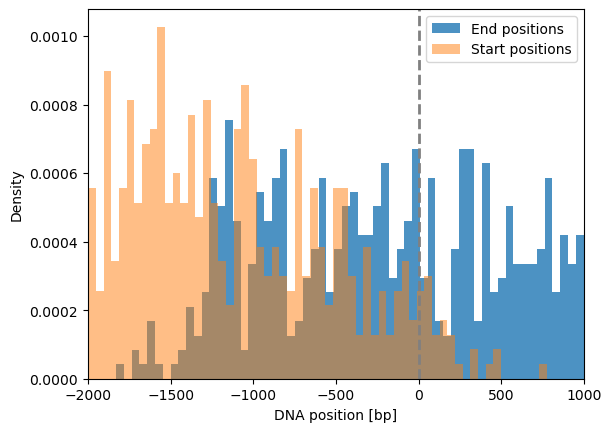

In [51]:
inter_start = -2000
inter_end = 1000
step = 200
inter = range(inter_start,inter_end+1,step)

plt.figure()

plt.hist(df_filtered['nuc_end_promo_rel'],  bins = 60, histtype='bar', density=True, label="End positions", alpha = 0.8)  
plt.hist(df_filtered['nuc_start_promo_rel'], bins = 60, histtype='bar', density=True, label="Start positions", alpha = 0.5)   

plt.xlabel("DNA position [bp]")
plt.ylabel("Density")

plt.xlim(-2000,1000)
plt.axvline(x=0, linestyle='dashed', linewidth=2, color='grey')
plt.legend()
plt.show()

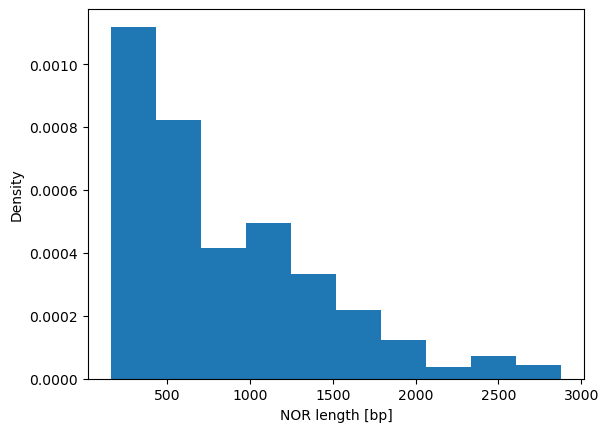

In [52]:
plt.figure()

plt.hist(df_filtered['region_length'], bins=10, histtype='bar', density=True)  

plt.xlabel("NOR length [bp]")
plt.ylabel("Density")
plt.show()

In [53]:
# promo_NDR_file = data_path + 'NDR.introns.intersect.bed'
# promo_HCG_file = data_path + 'HCG.introns.intersect.bed'
# outfile = data_path + 'introns.NDR.HCG.intersect.bed'
# nome.intersect_bed(promo_NDR_file, promo_HCG_file, outfile)

In [54]:
## inconsistant ordering error
## sort random file

# # sorting bed files introns

infile = data_path + 'HCG.random.introns.intersect.bed'
outfile = data_path + 'HCG.random.introns.intersect.sorted.bed'

nome.sort_bed(infile, outfile)

In [55]:
# promo_NDR_file = data_path + 'NDR.introns.intersect.bed'
# promo_HCG_file = data_path + 'HCG.random.introns.intersect.sorted.bed'
# outfile = data_path + 'introns.NDR.HCG.random.intersect.bed'
# nome.intersect_bed(promo_NDR_file, promo_HCG_file, outfile)

In [56]:
promo_NDR_file = data_path + 'NOR.introns.intersect.bed'
promo_HCG_file = data_path + 'HCG.introns.intersect.bed'
outfile = data_path + 'introns.NOR.HCG.intersect.bed'
nome.intersect_bed(promo_NDR_file, promo_HCG_file, outfile)

In [57]:
# promo_NDR_file = data_path + 'NOR.introns.intersect.bed'
# promo_HCG_file = data_path + 'HCG.random.introns.intersect.sorted.bed'
# outfile = data_path + 'introns.NOR.HCG.random.intersect.bed'
# nome.intersect_bed(promo_NDR_file, promo_HCG_file, outfile)

In [58]:
def normalize_clash_dict(x_y_clash_dict):
    min_clash = min(x_y_clash_dict.values())
    max_clash = max(x_y_clash_dict.values())

    x_y_clash_dict_norm = {k: (float(v-min_clash)/float(max_clash-min_clash))*100 for k, v in x_y_clash_dict.items()}
    return x_y_clash_dict_norm

In [59]:
import pickle
import scipy
from scipy import stats

In [60]:
infile = steric_path + 'x_y_dict'
with open(infile, 'rb') as fin:
    x_y_clash_dict = pickle.load(fin)

x_y_clash_dict_norm = normalize_clash_dict(x_y_clash_dict)

meth_thres_range = [0, 10, 20]
clash_thres_range = [5, 10, 20, 50]

params = []
for clash_thres in clash_thres_range:
    for meth_thres in meth_thres_range:
        k = "c" + str(clash_thres) + "m" + str(meth_thres)
        params.append(k)

In [61]:
def make_sliding_windows_file(df_promo_nuc_WGBS, x_y_clash_dict_norm):
    column_names = ["trans_id", "refid", "NOR_nbr", "window_nbr", "nbr_meth_CpGs", "nuc_region_length", "meth_rates_window"] 
    info_dict = dict()
    for col in column_names:
        info_dict[col] = []
        
    all_nuc_pos = x_y_clash_dict_norm.keys()
    nbr_bases_nuc = len(all_nuc_pos)
    
    all_trans_ids = list(set(list(df_promo_nuc_WGBS["trans_id"])))
    
    c = 0
    for trans_id in all_trans_ids:
        refid = trans_id.split("-")[0]
        c += 1
        
        df_WGBS_tmp = df_promo_nuc_WGBS.loc[df_promo_nuc_WGBS["trans_id"] == trans_id]
        
        NOR_number = 1
        nuc_region_starts = list(set(list(df_WGBS_tmp["nuc_region_start_genome"])))
        for NOR_start in nuc_region_starts:
            df_NOR_tmp = df_WGBS_tmp.loc[df_WGBS_tmp["nuc_region_start_genome"] == NOR_start]
            
            start = NOR_start
            win_nbr = 1
                    
            list_meth_positions = list(df_NOR_tmp["meth_start_genome"])
            list_meth_rates = list(df_NOR_tmp["meth_rate"])
            meth_dict_promoter = dict(zip(list_meth_positions, list_meth_rates))
    
            NOR_end = list(df_NOR_tmp["nuc_region_end_genome"])[0]
            
            while start + nbr_bases_nuc - 1 <= NOR_end:
                #get relative and absolute position+methylation
                window_start = start
                window_end = window_start+nbr_bases_nuc-1
                
                meth_in_window_tmp = dict()
                for meth_start_genome in meth_dict_promoter.keys():
                    if (window_start <= meth_start_genome) & (meth_start_genome <= window_end):
                        rel_pos = meth_start_genome-window_start+1
                        
                        meth_rate = meth_dict_promoter[meth_start_genome]
                        meth_in_window_tmp[rel_pos] = meth_rate
                
                if len(meth_in_window_tmp) != 0:
                    #exp
                    info_dict["trans_id"].append(trans_id)
                    info_dict["refid"].append(refid)
                    info_dict["NOR_nbr"].append(NOR_number)
                    info_dict["window_nbr"].append(win_nbr)
                    info_dict["nbr_meth_CpGs"].append(len(meth_in_window_tmp.keys()))
                    info_dict["nuc_region_length"].append(np.abs(NOR_end-NOR_start)+1)
                    info_dict["meth_rates_window"].append(meth_in_window_tmp)
                
                start += 1
                win_nbr += 1
        
            NOR_number += 1
                
                
    #Built dataframe
    df = pd.DataFrame(0, index = np.arange(len(info_dict["trans_id"])),columns = column_names)
    for feat in column_names:
        df[feat] = info_dict[feat]

    return df

In [62]:
def calc_perc_exp_clash_ident(x_y_clash_dict_norm, meth_in_window_tmp, meth_thres, clash_thres):    
    count_ident = 0
    cpg_positions = meth_in_window_tmp.keys()
    for meth_pos in cpg_positions:
        meth_rate = meth_in_window_tmp[meth_pos]
        clash_perc = x_y_clash_dict[meth_pos] 
        
        if meth_rate > meth_thres:
            if clash_perc <= clash_thres:
                count_ident += 1
        else:
            if clash_perc > clash_thres:
                count_ident += 1
                
    nbr_cpgs = len(cpg_positions)
    perc_exp_clash_ident = float(count_ident)/float(nbr_cpgs)
    
    return perc_exp_clash_ident

In [63]:
import re

def calc_score_lists(df_sliding_windows, x_y_clash_dict_norm, params):
    column_names = ["refid_NOR", "trans_id", "refid", "NOR_nbr", "window_nbr", "nbr_CpGs", "nuc_region_length"] + params
    info_dict = dict()
    for col in column_names:
        info_dict[col] = []
        
    all_refids = list(df_sliding_windows["refid"])
    all_NOR_nbrs = list(df_sliding_windows["NOR_nbr"])
    refid_NORs = []
    for ref, nor in zip(all_refids, all_NOR_nbrs):
        refid_NORs.append(str(ref)+"-"+str(nor))
    
    info_dict["refid_NOR"].extend(refid_NORs)
    info_dict["trans_id"].extend(list(df_sliding_windows["trans_id"]))
    info_dict["refid"].extend(all_refids)
    info_dict["NOR_nbr"].extend(all_NOR_nbrs)
    info_dict["window_nbr"].extend( list(df_sliding_windows["window_nbr"]))
    info_dict["nbr_CpGs"].extend(list(df_sliding_windows["nbr_meth_CpGs"])  )
    info_dict["nuc_region_length"].extend(list(df_sliding_windows["nuc_region_length"]))

    all_scores =  list(df_sliding_windows["meth_rates_window"]) #{34: 0.0, 35: 0.0,...}
    c = 0
    for row_df in range(len(all_scores)):
        c += 1
        
        # meth_rates_window = ast.literal_eval(all_scores[row_df])
        meth_rates_window = all_scores[row_df]
    
        for param_str in params:
            clash_thres = float(re.findall(r'\d+', param_str)[0]) #c5m0
            meth_thres = float(re.findall(r'\d+', param_str)[1])
            
            perc_clash_ident = calc_perc_exp_clash_ident(x_y_clash_dict_norm, meth_rates_window, meth_thres, clash_thres)
            info_dict[param_str].append(perc_clash_ident)
            
    #Built dataframe 
    df_scores = pd.DataFrame(0, index = np.arange(len(info_dict[column_names[0]])),columns = column_names)
    for feat in column_names:
        df_scores[feat] = info_dict[feat]

    return df_scores

In [64]:
def calculate_cohens_d(list_EXP,list_RAND):
    mEXP = np.mean(list_EXP)
    sdEXP = np.std(list_EXP)
    
    mRAND = np.mean(list_RAND)
    sdRAND = np.std(list_RAND)
    
    denom = np.sqrt(float(sdEXP**2 + sdRAND**2)/2.0)
    cohens_d = float(mEXP-mRAND)/float(denom)
    
    return cohens_d

def make_df_p_vals_cohens_d(df_scores_EXP, df_scores_RAND, params):
    column_names = ["nbr_CpGs", "parameter", "N_EXP", "N_RAND", "mean_EXP", "median_EXP", "std_EXP", "mean_RAND",
                    "median_RAND", "std_RAND", "cohens_d", "is_normal_EXP", "is_normal_RAND", "pval_ttest",
                    "t_stat", "pval_ranksums", "pval_ks_2samp"]
    info_dict = dict()
    for col in column_names:
        info_dict[col] = []

    nbr_CpGs_list = list(set(list(df_scores_EXP["nbr_CpGs"])))

    for nbr_CpGs in nbr_CpGs_list:
        df_scores_EXP_tmp = df_scores_EXP.loc[df_scores_EXP["nbr_CpGs"] == nbr_CpGs]
        df_scores_RAND_tmp = df_scores_RAND.loc[df_scores_RAND["nbr_CpGs"] == nbr_CpGs]
                    
        for p in range(len(params)):
            par_name = params[p]
            EXP_scores = list(df_scores_EXP_tmp[par_name])
            RAND_scores = list(df_scores_RAND_tmp[par_name])
            
            info_dict["nbr_CpGs"].append(nbr_CpGs)
            info_dict["parameter"].append(par_name)
            
            info_dict["N_EXP"].append(len(EXP_scores))
            info_dict["N_RAND"].append(len(RAND_scores))
            
            info_dict["mean_EXP"].append(np.mean(EXP_scores))
            info_dict["median_EXP"].append(np.median(EXP_scores))
            info_dict["std_EXP"].append(np.std(EXP_scores))
            
            info_dict["mean_RAND"].append(np.mean(RAND_scores))
            info_dict["median_RAND"].append(np.median(RAND_scores))
            info_dict["std_RAND"].append(np.std(RAND_scores))
            
            #EFFECT SIZE
            cohens_d = calculate_cohens_d(EXP_scores, RAND_scores)
            info_dict["cohens_d"].append(cohens_d)
            
            #STAT TESTS
            #is normal distributed? This function tests the null hypothesis that a sample comes from a normal distribution. If small -> ost likely not normal dustributed
            pval_normal_EXP = stats.normaltest(EXP_scores)[1] if len(EXP_scores) >= 8 else -1
            pval_normal_RAND = stats.normaltest(RAND_scores)[1] if len(EXP_scores) >= 8 else -1
            
            #students t
            ttest_res = stats.ttest_ind(EXP_scores,RAND_scores,equal_var = False)
            t_stat = ttest_res[0]
            p_val_ttest = float(ttest_res[1])/2.0
            
            #ranksums, kstest
            ranksums = scipy.stats.ranksums(EXP_scores,RAND_scores)[1]
            ks_2samp = scipy.stats.ks_2samp(EXP_scores,RAND_scores)[1]
    
            info_dict["is_normal_EXP"].append(pval_normal_EXP)
            info_dict["is_normal_RAND"].append(pval_normal_RAND)
            info_dict["pval_ttest"].append(p_val_ttest)
            info_dict["t_stat"].append(t_stat)
            info_dict["pval_ranksums"].append(ranksums)
            info_dict["pval_ks_2samp"].append(ks_2samp)
            
    #Built dataframe
    df = pd.DataFrame(0, index = np.arange(len(info_dict["nbr_CpGs"])),columns = column_names)
    for feat in column_names:
        df[feat] = info_dict[feat]

    return df

In [65]:
def plot_nbr_CpGs_cohensd(df_values, params):
    plt.figure(figsize=(15,7))
    ax = plt.subplot(1,1,1)
    
    nbr_CpGs_list = sorted(list(set(list(df_values["nbr_CpGs"]))))

    for par_name in params:
        
        df_values_tmp = df_values.loc[df_values["parameter"] == par_name]
        
        x_nbr_cpg_vals = list(df_values_tmp["nbr_CpGs"])
        y_cohens_d_vals = list(df_values_tmp["cohens_d"])
        
        if "m0" in par_name:
            c = "#117A65"
        if "m10" in par_name:
            c = "#45B39D"
        if "m20" in par_name:
            c = "#EB984E"
        if "c5" in par_name:
            m = "*"
            ms = 15
        if "c10" in par_name:
            m = "^"
            ms = 10
        if "c20" in par_name:
            m = "s"
            ms = 10
        if "c50" in par_name:
            m = "o"
            ms = 10
        
        
        plt.plot(x_nbr_cpg_vals, y_cohens_d_vals, linestyle="-", color=c, marker=m, markersize=ms, label=par_name)
    
    
    plt.axhline(y=0.2, linewidth=1, color = '#2C3E50',linestyle='--')
    plt.axhline(y=0.5, linewidth=1, color = '#2C3E50',linestyle='--')
    plt.axhline(y=0.8, linewidth=1, color = '#2C3E50',linestyle='--')
    
    e = 0.02
    ax.text(-1.8,0.2+e,"Small ES")
    ax.text(-1.8,0.5+e,"Medium ES")
    ax.text(-1.8,0.8+e,"Large ES")

    ax.set_ylabel("Cohen's d")
    ax.set_xlabel("Number of CpGs in sliding window")   

    plt.xlim(-2,35)
    plt.ylim(-3,3)

    legend = ax.legend(loc="lower left",ncol=4,frameon = 1,prop={'size':14})
    legend.get_frame().set_facecolor('white')

In [66]:
def plot_pvals_cohensd(df_values,params):
    
    plt.figure(figsize=(20,7))
    ax = plt.subplot(1,1,1)
    
    nbr_CpGs_list = sorted(list(set(list(df_values["nbr_CpGs"]))))
    
    for par_name in params:
        df_values_tmp = df_values.loc[df_values["parameter"] == par_name]
        
        x_nbr_cpg_vals = list(df_values_tmp["nbr_CpGs"])
        y_pvals_vals = list(df_values_tmp["pval_ranksums"])
        
        y_pvals_log = [-np.log10(p_val) if p_val != 0.0 else 310 for p_val in y_pvals_vals]
        
        if "m0" in par_name:
            c = "#117A65"
        if "m10" in par_name:
            c = "#45B39D"
        if "m20" in par_name:
            c = "#EB984E"
        if "c5" in par_name:
            m = "*"
            ms = 15
        if "c10" in par_name:
            m = "^"
            ms = 10
        if "c20" in par_name:
            m = "s"
            ms = 10
        if "c50" in par_name:
            m = "o"
            ms = 10
        
        
        plt.plot(x_nbr_cpg_vals,y_pvals_log,linestyle="-",color=c,marker=m,markersize=ms,label=par_name)
    
    
    #plt.axhline(y=-np.log10(0.05), linewidth=1, color = '#5D6D7E',linestyle='-')
    #plt.axhline(y=-np.log10(0.01), linewidth=1, color = '#515A5A',linestyle='-')

    ax.set_ylabel("-log10(p-value)")
    ax.set_xlabel("Number of CpGs in sliding window")   

    # plt.xlim(-2,35)
    # plt.ylim(0,450)

    legend = ax.legend(loc="upper right",ncol=4,frameon = 1,prop={'size':14})
    legend.get_frame().set_facecolor('white')

In [67]:
def plot_score_distribution(df_scores_EXP,df_scores_RAND,params):

    fig = plt.figure(figsize=(15,15))
    for idx, p in enumerate(range(len(params))):
        par_name = params[p]
        EXP_scores = list(df_scores_EXP[par_name])
        RAND_scores = list(df_scores_RAND[par_name])
                
        ttest_res = stats.ttest_ind(EXP_scores,RAND_scores,equal_var = False)
        t = ttest_res[0]
        p_val = float(ttest_res[1])/2.0
        
        
        ranksums = scipy.stats.ranksums(EXP_scores,RAND_scores)[1]
        ks_2samp = scipy.stats.ks_2samp(EXP_scores,RAND_scores)[1]

        #EFFECT SIZE
        cohens_d = calculate_cohens_d(EXP_scores,RAND_scores)
        
        #test for normal ditribution
        pval_normal_EXP = stats.normaltest(EXP_scores)[1] if len(EXP_scores) >= 8 else -1   #This function tests the null hypothesis that a sample comes from a normal distribution. If small -> ost likely not normal dustributed
        pval_normal_RAND = stats.normaltest(RAND_scores)[1] if len(EXP_scores) >= 8 else -1
                
        #PLOTTING
        bins = 20    
        
        ax = plt.subplot(4, 3, idx + 1)
        
        c1 = "#5499C7"
        c2 = "#7DCEA0"
        
        ax.annotate(par_name, xy=(0, 1), xycoords='axes fraction', fontsize=10, xytext=(5, -5), textcoords='offset points',ha='left', va='top') #region_name+" - "+

        plt.hist(np.array(EXP_scores), bins=bins, color=c1, label="Experimental", alpha=0.8)
        plt.hist(np.array(RAND_scores), bins=bins, color=c2, label="Random", alpha=0.8)
        
        # legend = ax.legend(loc="upper right",frameon = 1,prop={'size':16})
        # legend.get_frame().set_facecolor('white')
        
        plt.xlim(0,1)
        
        ax.set_xlabel("Matching score")
        ax.set_ylabel("Density")

In [68]:
def plot_hist_distr_CpGs(df_scores):  
    
    nbr_CpG_list = list(df_scores["nbr_CpGs"])
    x = sorted(list(set(nbr_CpG_list)))  
    y = [nbr_CpG_list.count(c) for c in x]  
    
    tot = len(nbr_CpG_list)
    p = 0
    for nbr_cpg,freq in zip(x,y):
        perc = (float(freq)/float(tot))*100
        p += perc
    
    for nbr_cpg_pos in range(len(x)):
        nbr_cpg = x[nbr_cpg_pos]
        freq = sum(y[nbr_cpg_pos:])
        perc = (float(freq)/float(tot))*100
    
    #PLOTTING
    bins = len(set(nbr_CpG_list))   
    
    fig = plt.figure()
    ax = plt.subplot(111)
    
    c1 = "#515A5A"
    c2 = "#7DCEA0"
    
    plt.hist(np.array(nbr_CpG_list), bins=bins, color=c1)
    # sns.distplot(np.array(nbr_CpG_list),norm_hist=True,kde=False,bins=bins,color=c1)   # norm_hist : bool, otional If True, the histogram height shows a density rather than a count. This is implied if a KDE or fitted density is plotted.
        
    ax.set_xlabel("Number of CpGs")
    ax.set_ylabel("Density")
    
    xticks = range(0,len(set(nbr_CpG_list)),5)
    plt.xlim(0,len(set(nbr_CpG_list))+1)
    plt.xticks([i+0.2 for i in xticks],xticks)


In [69]:
infile = data_path + 'introns.NDR.HCG.intersect.bed'
df = nome.get_nuc_pos_methylation(infile)

infile = data_path + 'introns.NDR.HCG.random.intersect.bed'
df_random = nome.get_nuc_pos_methylation(infile)

In [70]:
df.head()

,trans_id,refid,gene_name,chrom,promoter_start,promoter_end,TSS,TES,strand,nuc_region_start_genome,nuc_region_end_genome,nuc_region_length,meth_start_genome,meth_end_genome,meth_rate
0,NM_198317-894932,NM_198317,KLHL17,chr1,894932,897932,895963,901099,+,896516,896916,400,895035,895036,0.00
1,NM_198317-894932,NM_198317,KLHL17,chr1,894932,897932,895963,901099,+,896516,896916,400,895071,895072,0.00
2,NM_198317-894932,NM_198317,KLHL17,chr1,894932,897932,895963,901099,+,896516,896916,400,895185,895186,0.00
3,NM_198317-894932,NM_198317,KLHL17,chr1,894932,897932,895963,901099,+,896516,896916,400,895191,895192,0.00
4,NM_198317-894932,NM_198317,KLHL17,chr1,894932,897932,895963,901099,+,896516,896916,400,895214,895215,33.33


In [71]:
df_random.head()

,trans_id,refid,gene_name,chrom,promoter_start,promoter_end,TSS,TES,strand,nuc_region_start_genome,nuc_region_end_genome,nuc_region_length,meth_start_genome,meth_end_genome,meth_rate
0,NM_198317-894932,NM_198317,KLHL17,chr1,894932,897932,895963,901099,+,896516,896916,400,895035,895036,0.00
1,NM_198317-894932,NM_198317,KLHL17,chr1,894932,897932,895963,901099,+,896516,896916,400,895071,895072,28.57
2,NM_198317-894932,NM_198317,KLHL17,chr1,894932,897932,895963,901099,+,896516,896916,400,895185,895186,50.00
3,NM_198317-894932,NM_198317,KLHL17,chr1,894932,897932,895963,901099,+,896516,896916,400,895191,895192,0.00
4,NM_198317-894932,NM_198317,KLHL17,chr1,894932,897932,895963,901099,+,896516,896916,400,895214,895215,100.00


In [72]:
df_sliding_windows = make_sliding_windows_file(df, x_y_clash_dict_norm)
df_sliding_windows_random = make_sliding_windows_file(df_random, x_y_clash_dict_norm)

In [73]:
df_sliding_windows.head()

,trans_id,refid,NOR_nbr,window_nbr,nbr_meth_CpGs,nuc_region_length,meth_rates_window
0,NM_003456-3161488,NM_003456,1,1,1,221,{130: 0.0}
1,NM_003456-3161488,NM_003456,1,2,1,221,{129: 0.0}
2,NM_003456-3161488,NM_003456,1,3,1,221,{128: 0.0}
3,NM_003456-3161488,NM_003456,1,4,1,221,{127: 0.0}
4,NM_003456-3161488,NM_003456,1,5,1,221,{126: 0.0}


In [74]:
df_sliding_windows_random.head()

,trans_id,refid,NOR_nbr,window_nbr,nbr_meth_CpGs,nuc_region_length,meth_rates_window
0,NM_003456-3161488,NM_003456,1,1,1,221,{130: 100.0}
1,NM_003456-3161488,NM_003456,1,2,1,221,{129: 100.0}
2,NM_003456-3161488,NM_003456,1,3,1,221,{128: 100.0}
3,NM_003456-3161488,NM_003456,1,4,1,221,{127: 100.0}
4,NM_003456-3161488,NM_003456,1,5,1,221,{126: 100.0}


In [75]:
df_score_exp = calc_score_lists(df_sliding_windows, x_y_clash_dict_norm, params)
df_score_random = calc_score_lists(df_sliding_windows_random, x_y_clash_dict_norm, params)

In [76]:
df_score_exp.head()

,refid_NOR,trans_id,refid,NOR_nbr,window_nbr,nbr_CpGs,nuc_region_length,c5m0,c5m10,c5m20,c10m0,c10m10,c10m20,c20m0,c20m10,c20m20,c50m0,c50m10,c50m20
0,NM_003456-1,NM_003456-3161488,NM_003456,1,1,1,221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NM_003456-1,NM_003456-3161488,NM_003456,1,2,1,221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NM_003456-1,NM_003456-3161488,NM_003456,1,3,1,221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NM_003456-1,NM_003456-3161488,NM_003456,1,4,1,221,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NM_003456-1,NM_003456-3161488,NM_003456,1,5,1,221,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
df_score_random.head()

,refid_NOR,trans_id,refid,NOR_nbr,window_nbr,nbr_CpGs,nuc_region_length,c5m0,c5m10,c5m20,c10m0,c10m10,c10m20,c20m0,c20m10,c20m20,c50m0,c50m10,c50m20
0,NM_003456-1,NM_003456-3161488,NM_003456,1,1,1,221,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,NM_003456-1,NM_003456-3161488,NM_003456,1,2,1,221,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,NM_003456-1,NM_003456-3161488,NM_003456,1,3,1,221,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,NM_003456-1,NM_003456-3161488,NM_003456,1,4,1,221,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,NM_003456-1,NM_003456-3161488,NM_003456,1,5,1,221,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0


In [78]:
df_pvalues = make_df_p_vals_cohens_d(df_score_exp, df_score_random, params)

In [79]:
df_pvalues.head()

,nbr_CpGs,parameter,N_EXP,N_RAND,mean_EXP,median_EXP,std_EXP,mean_RAND,median_RAND,std_RAND,cohens_d,is_normal_EXP,is_normal_RAND,pval_ttest,t_stat,pval_ranksums,pval_ks_2samp
0,1,c5m0,153157,153157,0.476785,0.0,0.499461,0.429971,0.0,0.495072,0.094143,0.0,0.0,9.302789e-150,26.052005,1.653895e-111,2.765978e-146
1,1,c5m10,153157,153157,0.477040,0.0,0.499473,0.430336,0.0,0.495123,0.093914,0.0,0.0,4.839057e-149,25.988585,5.462209e-111,1.358293e-145
2,1,c5m20,153157,153157,0.493467,0.0,0.499957,0.441325,0.0,0.496545,0.104651,0.0,0.0,1.883350e-184,28.959661,7.417712e-138,2.154689e-181
3,1,c10m0,153157,153157,0.487624,0.0,0.499847,0.462852,0.0,0.498618,0.049620,0.0,0.0,3.398471e-43,13.731227,1.627855e-32,2.961942e-41
4,1,c10m10,153157,153157,0.487800,0.0,0.499851,0.463035,0.0,0.498632,0.049606,0.0,0.0,3.584578e-43,13.727362,1.689911e-32,3.112418e-41


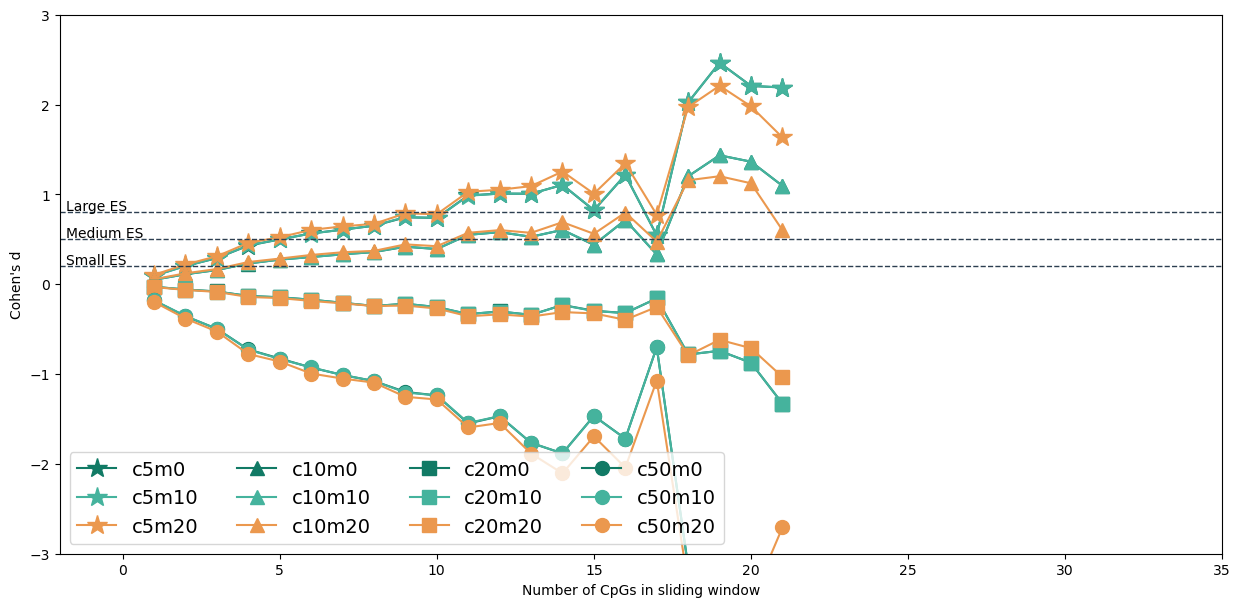

In [80]:
plot_nbr_CpGs_cohensd(df_pvalues, params)

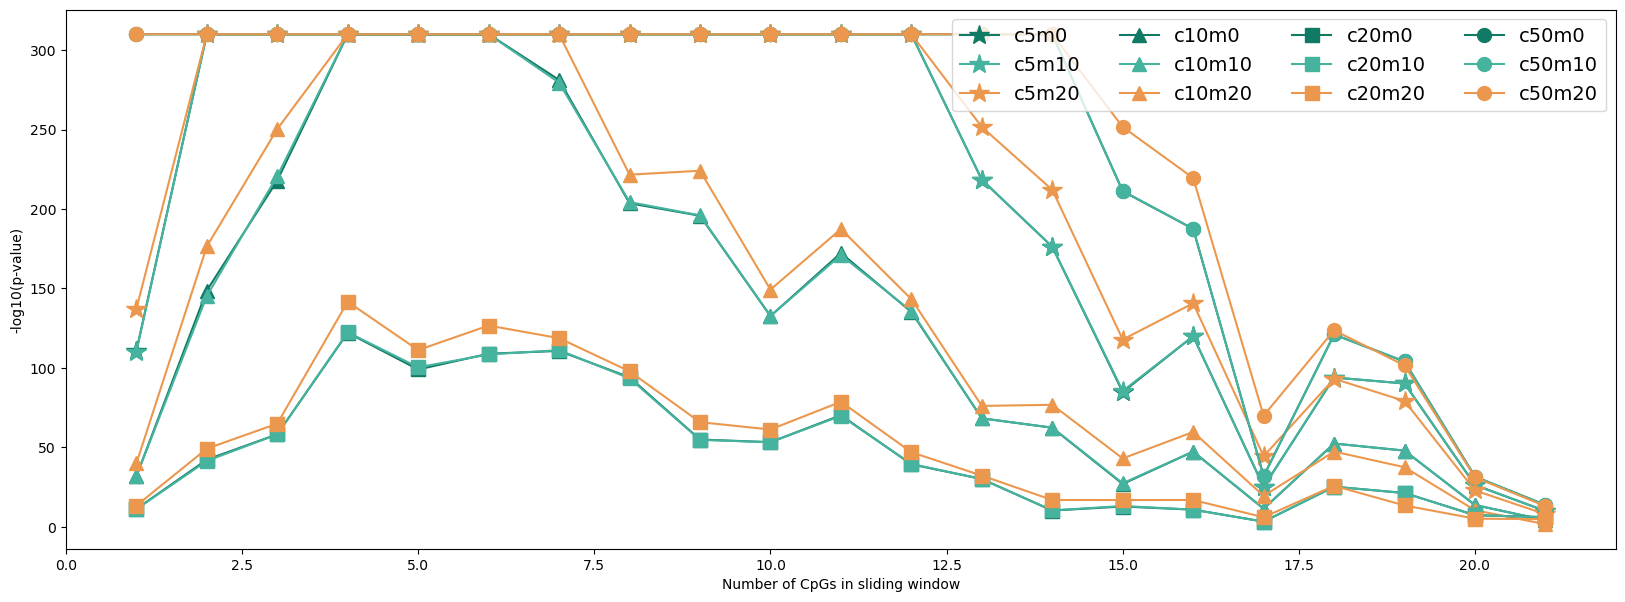

In [81]:
plot_pvals_cohensd(df_pvalues, params)

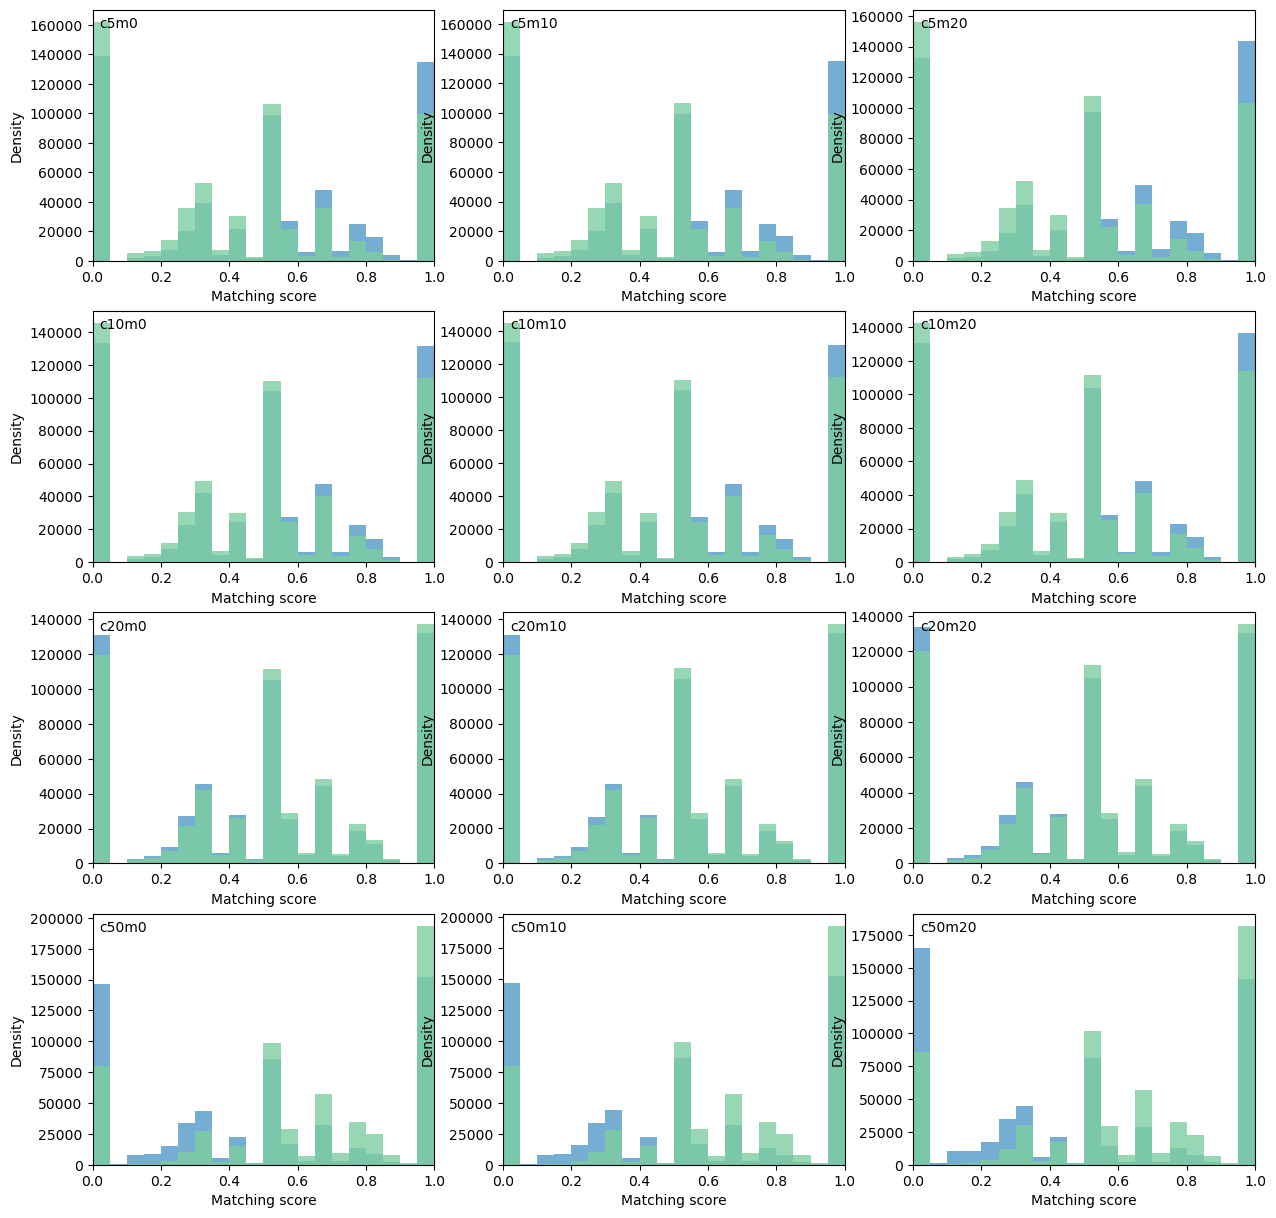

In [82]:
plot_score_distribution(df_score_exp,df_score_random,params)

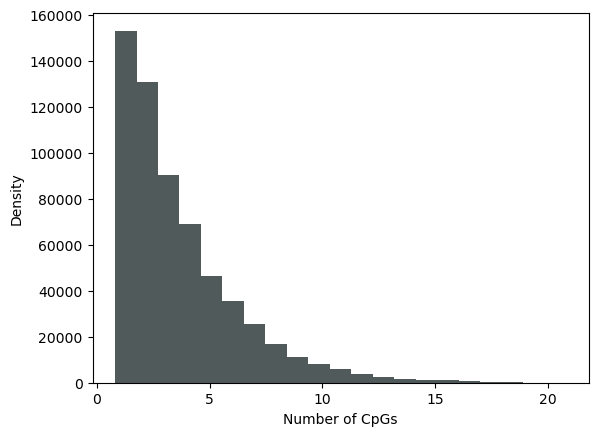

In [83]:
plot_hist_distr_CpGs(df_score_exp)

In [84]:
infile = data_path + 'introns.NOR.HCG.intersect.bed'
df = nome.get_nuc_pos_methylation(infile)

infile = data_path + 'introns.NOR.HCG.random.intersect.bed'
df_random = nome.get_nuc_pos_methylation(infile)

In [85]:
df_sliding_windows = make_sliding_windows_file(df, x_y_clash_dict_norm)
df_sliding_windows_random = make_sliding_windows_file(df_random, x_y_clash_dict_norm)

In [86]:
df_score_exp = calc_score_lists(df_sliding_windows, x_y_clash_dict_norm, params)
df_score_random = calc_score_lists(df_sliding_windows_random, x_y_clash_dict_norm, params)

In [87]:
df_pvalues = make_df_p_vals_cohens_d(df_score_exp, df_score_random, params)

/home/kevin/miniconda3/envs/helms-lab/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


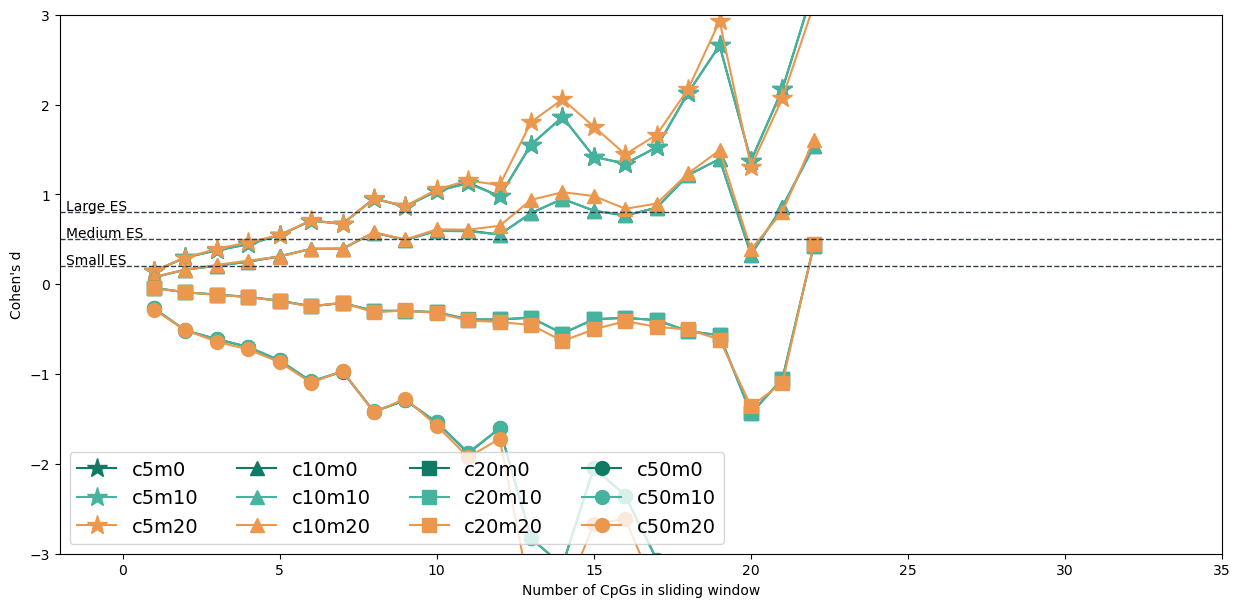

In [88]:
plot_nbr_CpGs_cohensd(df_pvalues, params)

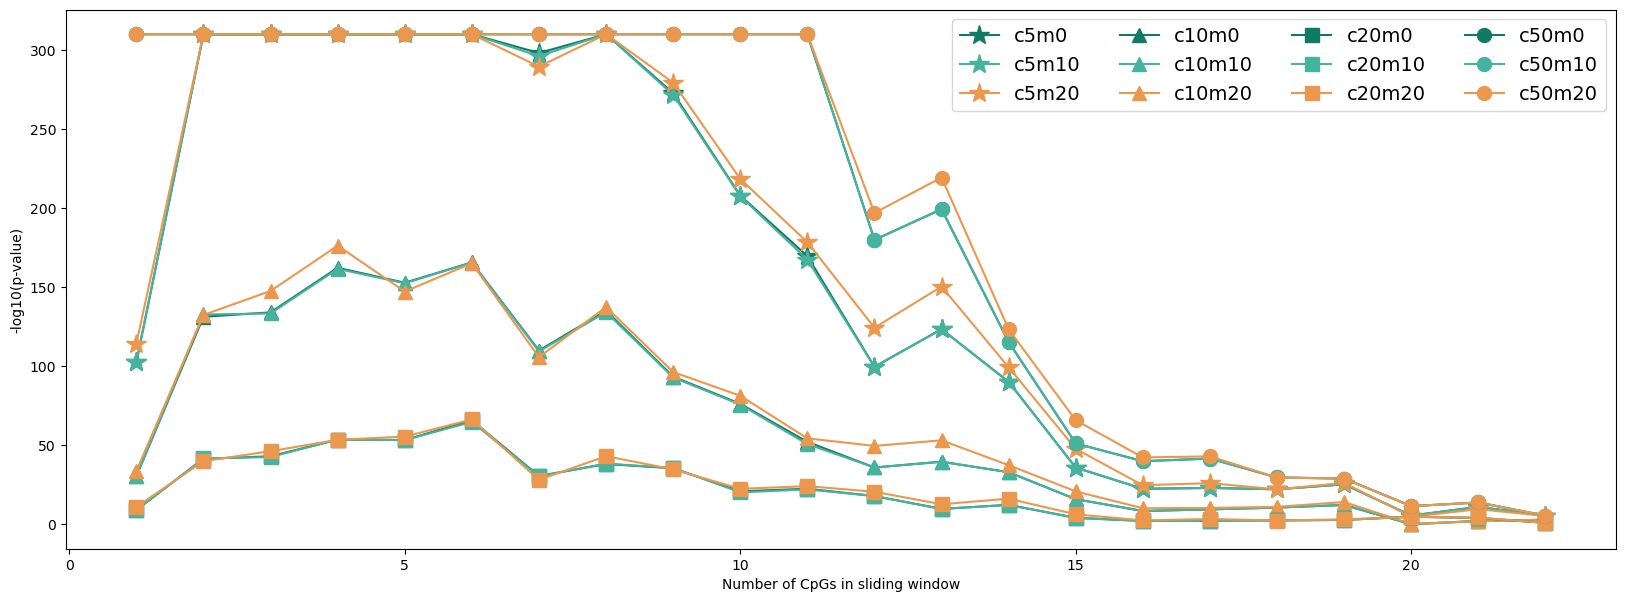

In [89]:
plot_pvals_cohensd(df_pvalues, params)

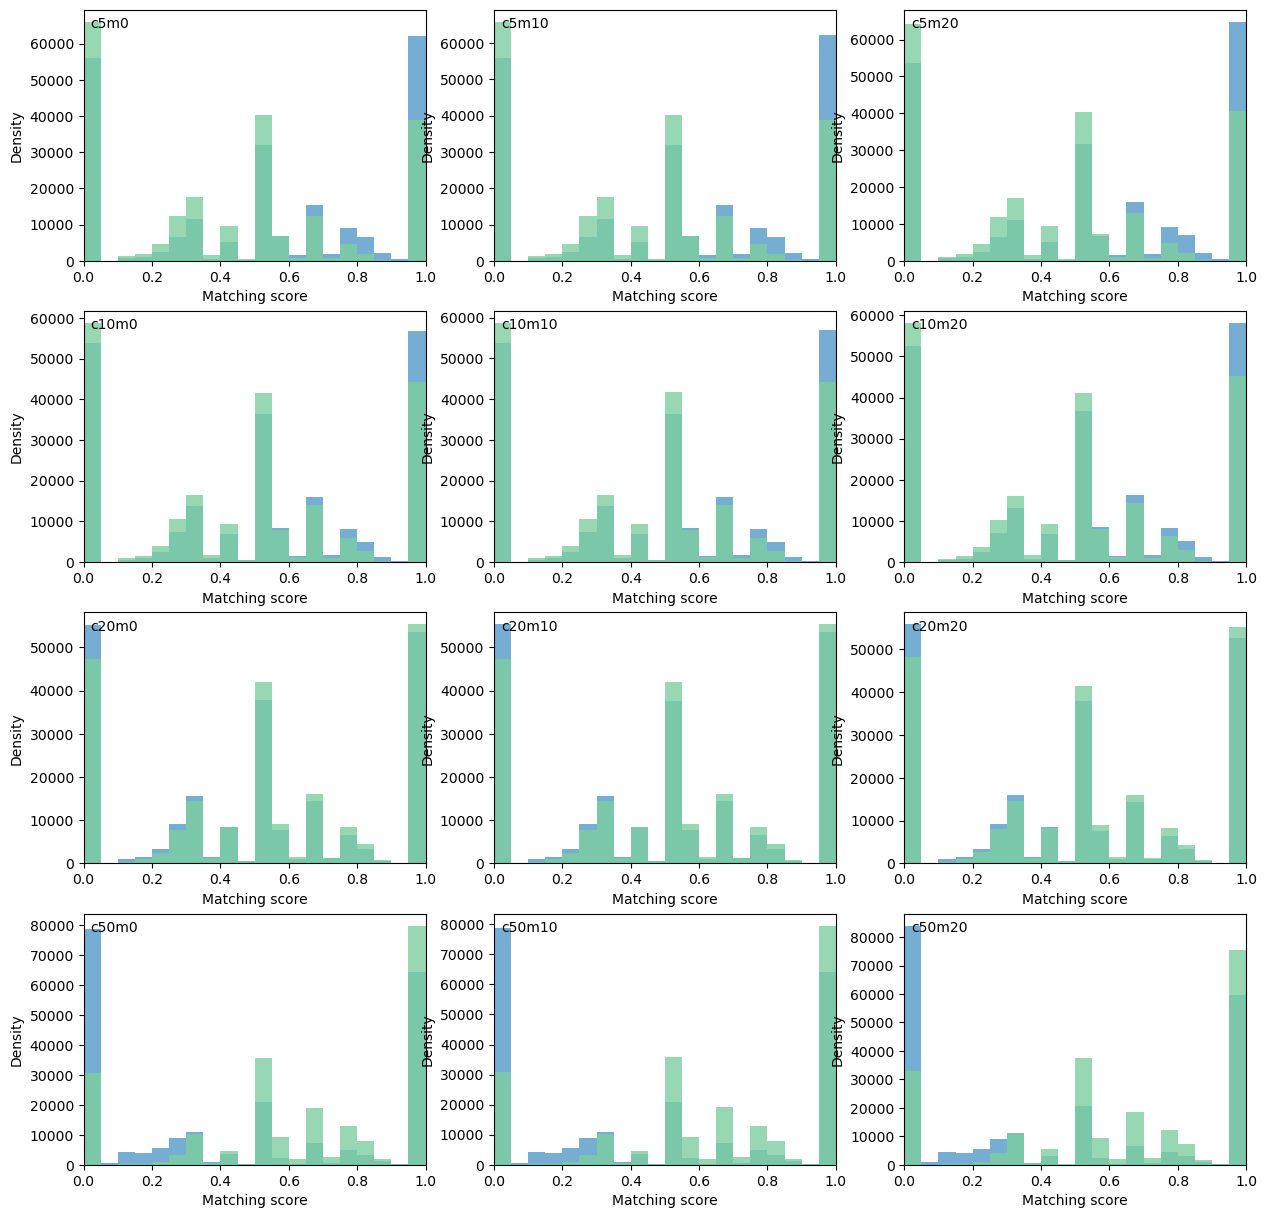

In [90]:
plot_score_distribution(df_score_exp,df_score_random,params)

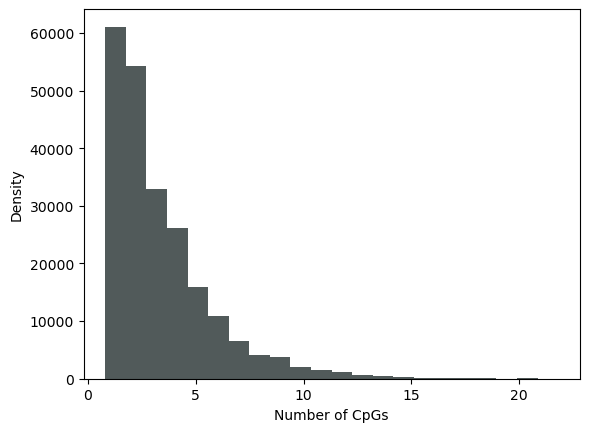

In [91]:
plot_hist_distr_CpGs(df_score_exp)